This notebook contains all generative model classes and a general script for training them. The same function samples from each generative model and both saves and plots the results.

# Imports

In [1]:
import os
from typing import Type
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sbibm
import seaborn as sns
import bayesflow as bf
import bayesflow.benchmarks.lotka_volterra as lotka_volterra
import bayesflow.benchmarks.sir as SIR
import nflows.nn.nets as nets
from nflows.transforms.base import CompositeTransform
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform, MaskedPiecewiseLinearAutoregressiveTransform   # MAF 
from nflows.transforms import PiecewiseRationalQuadraticCouplingTransform #NSF
from nflows.transforms import PiecewiseCubicCouplingTransform, PiecewiseQuadraticCouplingTransform
from nflows.transforms import Permutation
from generate_dataset import generate_dataset

C:\Users\cooli\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm





# cVAE Framework

In [2]:
class Encoder(nn.Module):
    """
    Encoder for q(z | theta, y).
    Inputs: theta (parameter) and y (observation), concatenated.
    Outputs: mu and log_var for latent variable z (dimension z_dim).
    """
    def __init__(self, theta_dim, y_dim, z_dim, hidden_dim: list):
        super(Encoder, self).__init__()
        hidden_dim.insert(0, theta_dim + y_dim) #Inserting initial amount of neurons
        layers = []
        
        #Converting list of neurons to pytorch architecture
        for i in range(len(hidden_dim) - 1):
            layers.append(nn.Linear(hidden_dim[i], hidden_dim[i + 1]))
            layers.append(nn.LeakyReLU(0.1))
            layers.append(nn.LayerNorm(hidden_dim[i + 1]))

        mu_layers = [nn.Linear(hidden_dim[-1], z_dim)]
        log_var_layers = [nn.Linear(hidden_dim[-1], z_dim)]

        #Defining layers from lists
        self.net = nn.Sequential(*layers)
        self.mu = mu_layers[0]
        self.log_var = log_var_layers[0]

        #Storing layer info for printing
        self.layers = layers
        self.out_layers = mu_layers

    def forward(self, theta, y):
        inp = torch.cat([theta, y], dim=1)
        h = self.net(inp)
        return self.mu(h), self.log_var(h)


class Decoder(nn.Module):
    """
    Decoder for p(theta | z, y).
    Inputs: z (latent) and y (observation), concatenated.
    Outputs: mu and log_var for theta (reconstruction).
    """
    def __init__(self, z_dim, y_dim, theta_dim, hidden_dim: list):
        super(Decoder, self).__init__()
        hidden_dim.insert(0, z_dim + y_dim)
        layers = []
        
        for i in range(len(hidden_dim) - 1):
            layers.append(nn.Linear(hidden_dim[i], hidden_dim[i + 1]))
            layers.append(nn.LeakyReLU(0.1))
            layers.append(nn.LayerNorm(hidden_dim[i + 1]))

        mu_layers = [nn.Linear(hidden_dim[-1], theta_dim)]
        log_var_layers = [nn.Linear(hidden_dim[-1], theta_dim)]

        #Defining layers from lists
        self.net = nn.Sequential(*layers)
        self.mu = mu_layers[0]
        self.log_var = log_var_layers[0]

        #Storing layer info
        self.layers = layers
        self.out_layers = mu_layers

    def forward(self, z, y):
        inp = torch.cat([z, y], dim=1)
        h = self.net(inp)
        return self.mu(h), self.log_var(h)
    

class PriorNetwork(nn.Module):
    """
    Prior network for p(z | y).
    Input: y (observation).
    Outputs: mu and log_var for latent variable z (dimension z_dim).
    """
    def __init__(self, y_dim, z_dim, hidden_dim: list):
        super(PriorNetwork, self).__init__()
        
        hidden_dim.insert(0, y_dim)
        layers = []
        
        for i in range(len(hidden_dim) - 1):
            layers.append(nn.Linear(hidden_dim[i], hidden_dim[i + 1]))
            layers.append(nn.LeakyReLU(0.1))
            layers.append(nn.LayerNorm(hidden_dim[i + 1]))

        mu_layers = [nn.Linear(hidden_dim[-1], z_dim)]
        log_var_layers = [nn.Linear(hidden_dim[-1], z_dim)]

        #Defining layers from lists
        self.net = nn.Sequential(*layers)
        self.mu = mu_layers[0]
        self.log_var = log_var_layers[0]

        #Storing layer info
        self.layers = layers
        self.out_layers = mu_layers

    def forward(self, y):
        h = self.net(y)
        return self.mu(h), self.log_var(h)

# Independent cVAE

In [3]:
class Independent_cVAE(nn.Module):
    """
    Complete Conditional VAE:
      - Encoder:   q(z | theta, y)
      - Prior:     p(z | y)
      - Decoder:   p(theta | z, y)

    Parameters:
      theta: parameter of interest (dimension theta_dim)
      y: observation (dimension y_dim)
      z: latent variable (dimension z_dim)
    """
    def __init__(self, theta_dim: int, y_dim: int, z_dim: int,
                 encoder_hidden_dim: list,
                 decoder_hidden_dim: list,
                 init_type='kaiming_normal'):
        super(Independent_cVAE, self).__init__()
        self.encoder = Encoder(theta_dim, y_dim, z_dim, hidden_dim=encoder_hidden_dim)
        self.decoder = Decoder(z_dim, y_dim, theta_dim, hidden_dim=decoder_hidden_dim)
        self._init_weights(init_type)

        self.theta_dim = theta_dim
        self.y_dim = y_dim
        self.z_dim = z_dim

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, theta, y):
        # Encoder: q(z | theta, y)
        mu_q, log_var_q = self.encoder(theta, y)
        # Sample latent variable z ~ q(z | theta, y)
        z = self.reparameterize(mu_q, log_var_q)
        # Decoder: p(theta | z, y)
        mu_theta, log_var_theta = self.decoder(z, y)
        return theta, mu_q, log_var_q, mu_theta, log_var_theta

    def loss_function(self, theta, mu_q, log_var_q, mu_theta, log_var_theta, beta):
        # Convert log-variances to variances
        var_q = torch.exp(log_var_q)
        var_theta = torch.exp(log_var_theta)

        # KL divergence between q(z|theta,y)=N(mu_q,var_q) and p(z)=N(0,I)
        KL = beta * -0.5 * torch.mean(
            log_var_q - torch.pow(mu_q,2) - var_q + 1
        )

        # Gaussian Negative Log-Likelihood for theta reconstruction (ignoring constants)
        NLL = torch.mean(
            log_var_theta + torch.pow(theta - mu_theta, 2) / var_theta
        )
        return KL, NLL, KL + NLL

    def sample(self, num_samples, y):
        # Set the model to evaluation mode
        self.eval()
        with torch.no_grad():
            # Ensure y is a float tensor and repeat for num_samples
            y = torch.as_tensor(y, dtype=torch.float32).repeat(num_samples, 1)
            z_dim = self.encoder.mu.out_features  # Get latent space dimension
            z = torch.randn(num_samples, z_dim, device=y.device)
            # Decode to get theta reconstruction parameters
            mu_theta, log_var_theta = self.decoder(z, y)
            # Sample theta using the reparameterization trick
            theta = self.reparameterize(mu_theta, log_var_theta)
        return theta

    def _init_weights(self, init_type):
        """
        Initialize weights in the network with different methods:
        - xavier_uniform
        - xavier_normal
        - kaiming_uniform (He)
        - kaiming_normal 
        - orthogonal
        Biases are set to zero by default.
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if init_type == 'xavier_uniform':
                    nn.init.xavier_uniform_(m.weight)
                    nn.init.zeros_(m.bias)
                elif init_type == 'xavier_normal':
                    nn.init.xavier_normal_(m.weight)
                    nn.init.zeros_(m.bias)
                elif init_type == 'kaiming_uniform':
                    # For ReLU or similar activations
                    nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                    nn.init.zeros_(m.bias)
                elif init_type == 'kaiming_normal':
                    # For ReLU or similar activations
                    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                    nn.init.zeros_(m.bias)
                elif init_type == 'orthogonal':
                    nn.init.orthogonal_(m.weight)
                    nn.init.zeros_(m.bias)
                else:
                    raise ValueError(f"Unknown init_type {init_type}")
                
    def print_info(self):
        encoder = "\n"
        out_encoder = ""
        decoder = "\n"
        out_decoder = ""

        for elmt in self.encoder.layers:
            encoder += str(elmt) + "\n"

        for elmt in self.encoder.out_layers:
            out_encoder += str(elmt) + "\n"

        for elmt in self.decoder.layers:
            decoder += str(elmt) + "\n"

        for elmt in self.decoder.out_layers:
            out_decoder += str(elmt) + "\n"

        print(f"====================================================\n\
Model: {self.__class__.__name__}\n\
\n\tArchitecture encoder: {encoder}\
{out_encoder}\n\
\tArchitecture decoder: {decoder}\
{out_decoder} \n\
Theta dim: {self.theta_dim}\n\
y dim: {self.y_dim}\n\
z dim: {self.z_dim}\n\
====================================================")

# Dependent cVAE

In [4]:
class Dependent_cVAE(nn.Module):
    """
    Complete Conditional VAE:
      - Encoder:   q(z | theta, y)
      - Prior:     p(z | y)
      - Decoder:   p(theta | z, y)

    Parameters:
      theta: parameter of interest (dimension theta_dim)
      y: observation (dimension y_dim)
      z: latent variable (dimension z_dim)
    """
    def __init__(self, theta_dim, y_dim, z_dim,
                 encoder_hidden_dim: list,
                 prior_hidden_dim: list,
                 decoder_hidden_dim: list,
                 init_type='xavier_uniform'):
        super(Dependent_cVAE, self).__init__()
        self.encoder = Encoder(theta_dim, y_dim, z_dim, hidden_dim=encoder_hidden_dim)
        self.prior = PriorNetwork(y_dim, z_dim, hidden_dim=prior_hidden_dim)
        self.decoder = Decoder(z_dim, y_dim, theta_dim, hidden_dim=decoder_hidden_dim)
        self._init_weights(init_type)

        self.theta_dim = theta_dim
        self.y_dim = y_dim
        self.z_dim = z_dim

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, theta, y):
        # Encoder: q(z | theta, y)
        mu_q, log_var_q = self.encoder(theta, y)
        # Prior: p(z | y)
        mu_p, log_var_p = self.prior(y)
        # Sample latent variable z ~ q(z | theta, y)
        z = self.reparameterize(mu_q, log_var_q)
        # Decoder: p(theta | z, y)
        mu_theta, log_var_theta = self.decoder(z, y)
        return theta, mu_q, log_var_q, mu_p, log_var_p, mu_theta, log_var_theta

    def loss_function(self, theta, mu_q, log_var_q, mu_p, log_var_p, mu_theta, log_var_theta, beta):
        # Convert log-variances to variances
        var_q = torch.exp(log_var_q)
        var_p = torch.exp(log_var_p)
        var_theta = torch.exp(log_var_theta)

        # KL divergence between q(z|theta,y)=N(mu_q,var_q) and p(z|y)=N(mu_p,var_p)
        KL = beta * 0.5 * torch.mean(
            (log_var_p - log_var_q) + (var_q + (mu_q - mu_p)**2) / var_p - 1
        )
        # Gaussian Negative Log-Likelihood for theta reconstruction (ignoring constants)
        NLL = torch.mean(
            log_var_theta + torch.pow(theta - mu_theta, 2) / (var_theta)
        )
        return KL, NLL, KL + NLL

    def sample(self, num_samples, y):
        # Set the model to evaluation mode
        self.eval()
        with torch.no_grad():
            # Ensure y is a float tensor and repeat for num_samples
            y = torch.as_tensor(y, dtype=torch.float32).repeat(num_samples, 1)
            # Obtain latent parameters from the prior network
            mu_p, log_var_p = self.prior(y)
            # Reparameterize to sample z
            z = self.reparameterize(mu_p, log_var_p)
            # Decode to get theta reconstruction parameters
            mu_theta, log_var_theta = self.decoder(z, y)
            # Sample theta using the reparameterization trick
            theta = self.reparameterize(mu_theta, log_var_theta)
        return theta

    def _init_weights(self, init_type):
        """
        Initialize weights in the network with different methods:
        - xavier_uniform
        - xavier_normal
        - kaiming_uniform (He)
        - kaiming_normal
        - orthogonal
        Biases are set to zero by default.

        Usage:
        Call this inside your model's __init__ or a separate initialization method.
            Example:
            self._init_weights(init_type='xavier_uniform')
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if init_type == 'xavier_uniform':
                    nn.init.xavier_uniform_(m.weight)
                    nn.init.zeros_(m.bias)
                elif init_type == 'xavier_normal':
                    nn.init.xavier_normal_(m.weight)
                    nn.init.zeros_(m.bias)
                elif init_type == 'kaiming_uniform':
                    # For ReLU or similar activations
                    nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                    nn.init.zeros_(m.bias)
                elif init_type == 'kaiming_normal':
                    # For ReLU or similar activations
                    nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                    nn.init.zeros_(m.bias)
                elif init_type == 'orthogonal':
                    nn.init.orthogonal_(m.weight)
                    nn.init.zeros_(m.bias)
                else:
                    raise ValueError(f"Unknown init_type {init_type}")

    def print_info(self):
            encoder = "\n"
            out_encoder = ""
            prior = "\n"
            out_prior = ""
            decoder = "\n"
            out_decoder = ""

            for elmt in self.encoder.layers:
                encoder += str(elmt) + "\n"

            for elmt in self.encoder.out_layers:
                out_encoder += str(elmt) + "\n"

            for elmt in self.prior.layers:
                prior += str(elmt) + "\n"

            for elmt in self.prior.out_layers:
                out_prior += str(elmt) + "\n"

            for elmt in self.decoder.layers:
                decoder += str(elmt) + "\n"

            for elmt in self.decoder.out_layers:
                out_decoder += str(elmt) + "\n"

            print(f"====================================================\n\
Model: {self.__class__.__name__}\n\
\n\tArchitecture Encoder: {encoder}\
{out_encoder}\n\
\tArchitecture Prior: {prior}\
{out_prior}\n\
\tArchitecture Decoder: {decoder}\
{out_decoder} \n\
Theta dim: {self.theta_dim}\n\
y dim: {self.y_dim}\n\
z_dim: {self.z_dim}\n\
====================================================")

# Masked Autoregressive Flows (MAF)

In [5]:
class MAF(nn.Module):
    def __init__(self, theta_dim,
                       y_dim,
                       num_transforms, 
                       hidden_dim, 
                       num_blocks,
                       transform = MaskedAffineAutoregressiveTransform, 
                       activation = F.elu,
                       use_residual_blocks = True, 
                       random_mask = False,
                       dropout_probability = 0.0,
                       use_batch_norm = True):
        super().__init__()

        self.theta_dim = theta_dim
        self.y_dim = y_dim
        self.num_transforms = num_transforms
        self.hidden_dim = hidden_dim
        self.num_blocks = num_blocks
        self.transform = transform 

        #Defining base distribution
        base_dist = StandardNormal(shape=[theta_dim])
        self.base_dist = base_dist

        

        #Defining each transformation using the chosen spline
        transforms = []
        for _ in range(num_transforms):
            transforms.append(transform(features=theta_dim,
                                        hidden_features=hidden_dim,
                                        context_features=y_dim,
                                        num_blocks=num_blocks,
                                        use_residual_blocks=use_residual_blocks,
                                        random_mask=random_mask,
                                        activation=activation,
                                        dropout_probability=dropout_probability,
                                        use_batch_norm=use_batch_norm))
            #Activating permutation
            perm = torch.randperm(theta_dim)
            perm_transform = Permutation(perm)
            transforms.append(perm_transform)


        #Combine all transformations and define the model
        transform = CompositeTransform(transforms)
        self.flow = Flow(transform, base_dist)
        
     #Forward pass is calculating the loss function directly
    def forward(self, theta, y):
        return self.flow.log_prob(theta, context=y).mean()
        
    def sample(self, num_samples, y):
        return self.flow.sample(num_samples, context=y)

    def print_info(self):

        print(f"====================================================\n\
\tModel: {self.__class__.__name__}\n\
\n\tTransformation: {self.transform}\
\n\tBase distribution: {self.base_dist}\
\n\tNumber of transformations: {self.num_transforms}\
\n\tNumber of residual blocks: {self.num_blocks}\
\n\tHidden features: {self.hidden_dim}\
\n\tTheta dim: {self.theta_dim}\
\n\ty dim: {self.y_dim}\n\
====================================================")
        

# Neural Spline Flows (NSF)

In [7]:
class NSF(nn.Module):
    def __init__(self, theta_dim,
                       y_dim,
                       num_transforms, 
                       hidden_dim, 
                       num_blocks,
                       spline,
                       tail_bound,
                       tails = "linear", 
                       activation = F.elu, 
                       use_batch_norm = True):

        super().__init__()

        #Save input arguments for printing 
        self.theta_dim = theta_dim
        self.y_dim = y_dim
        self.num_transforms = num_transforms
        self.hidden_dim = hidden_dim
        self.num_blocks = num_blocks
        self.spline = spline
        self.tail_bound = tail_bound
        self.tails = tails
        self.activation = activation
        self.use_batch_norm = use_batch_norm

        #Defining base distribution
        base_dist = StandardNormal(shape=[theta_dim])
        self.base_dist = base_dist

        #Activating permutation
        perm = torch.randperm(theta_dim)
        perm_transform = Permutation(perm)

        #Defining each transformation using the chosen spline
        transforms = []
        for i in range(num_transforms):

            #mask for coupling
            mask = torch.arange(theta_dim) % 2 == i % 2
            mask = mask[torch.randperm(theta_dim)]

            transforms.append(spline(mask,
                                     self._create_resinet(
                                     context_features=y_dim,
                                     hidden_features=hidden_dim,
                                     num_blocks=num_blocks,
                                     use_batch_norm=use_batch_norm,
                                     activation=activation), tail_bound=tail_bound,
                                                             tails=tails))
            
            transforms.append(perm_transform)


        #Combine all transformations and define the model
        transform = CompositeTransform(transforms)
        self.flow = Flow(transform, base_dist)



    #Function for creating the residual net, controlling the parameters of the spline
    def _create_resinet(self, context_features: int, 
                              hidden_features: int,
                              num_blocks: int,
                              use_batch_norm: bool,
                              activation: Type):
        def func(in_dim: int, out_dim: int):
            return nets.ResidualNet(in_dim, 
                                    out_dim, 
                                    hidden_features=hidden_features,
                                    context_features=context_features, 
                                    num_blocks=num_blocks, 
                                    activation=activation, 
                                    use_batch_norm=use_batch_norm)  
        return func
    
    #Forward pass is calculating the loss function directly
    def forward(self, theta, y):
        return self.flow.log_prob(theta, context=y).mean()
    
    def loss(self, theta, y):
        num_samples = theta.shape[0]
        u = self.base_dist._sample(num_samples=num_samples, context=None)
        
        
        
    def sample(self, num_samples, y):
        return self.flow.sample(num_samples, context=y)

    def print_info(self):

        print(f"====================================================\n\
\tModel: {self.__class__.__name__}\n\
\n\tSpline: {self.spline}\
\n\tBase distribution: {self.base_dist}\
\n\tNumber of transformations: {self.num_transforms}\
\n\tNumber of residual blocks: {self.num_blocks}\
\n\tHidden features: {self.hidden_dim}\
\n\tTheta dim: {self.theta_dim}\
\n\ty dim: {self.y_dim}\n\
====================================================")
        


# Function for running a model

In [ ]:
def run_model(model, 
              num_samples: int,
              task_name: str, 
              learning_rate: float,
              batch_size: int,
              epochs: int,
              early_stopping_patience: int,
              scaler = StandardScaler,
              cvae_z_dim: int = 0,
              cvae_beta: int = 0,
              cvae_gradient_clipping_threshold: int = 10,
              cvae_encoder_hidden_dim: list = [],
              cvae_decoder_hidden_dim: list = [],
              cvae_prior_hidden_dim: list = [],
              cvae_init_weight_type: str = 'kaiming_normal',
              nflows_NSF_spline: Type = None, 
              nflows_NSF_tail_bound: int = 0,
              nflows_MAF_transform: Type = None,
              nflows_MAF_use_residual_block: bool = True,
              nflows_MAF_random_mask: bool = False,
              nflows_MAF_dropout_probability: float = 0.0,
              nflows_num_transforms: int = 0,
              nflows_hidden_dim: int = 0,
              nflows_num_blocks: int = 0,
              nflows_use_batch_norm = True,
              nflows_activation_func = F.elu,
              save_model: bool = False,
              save_fig: bool = False,
              save_generated_dataset: bool = False,
              seed: int = 0):
    
    """
    For a given generative model and model parameters, the function trains it on samples from a prior distribution
    and a likelihood. The model should then be able to generate samples for the posterior distribution.
    The samples are plotted against the true posterior distribution and such figure is displayed in the end.
    
    Args:
        -- Shared Parameters -- 
        num_samples: Number of samples the model should be trained on.
        task_name: The name of the benchmark model to approximate the posterior of. 
        learning_rate: The learning rate during training.
        batch_size: Batch size for the training dataset
        epochs: Number of epochs.
        early_stopping_patience: Early stopping criteria.
        scaler: Scaler for training/validation dataset. Default is StandardScaler

        -- cVAE Parameters -- 
        cvae_z_dim: latent space dimension
        cvae_beta: Beta factor for loss function
        cvae_gradient_clipping_threshold: Threshold for gradient clipping. Default 10.
        cvae_encoder_hidden_dim: List of encoder hidden dimensions and layers.
        cvae_decoder_hidden_dim: List of decoder hidden dimensions and layers.
        cvae_prior_hidden_dim: List of prior hidden dimensions and layers (If dependent cVAE)
        cvae_init_weight_type: Weight initializer for more efficient training. Default "kaiming_normal"

        -- Flow Based Methods Parameters -- 
        nflows_num_transforms: Number of transformations
        nflows_hidden_dim: Hidden dimension of Residual networks
        nflows_num_blocks: Number of Residual network blocks
        nflows_spline: The spline to use from nflows.transforms
        nflows_tail_bound: The tail bound for the spline.

        -- Saving Model -- 
        save_model: 'True' to save the trained model.pth
        save_fig: 'True' to save the figure of generated vs true posterior
        save_generated_dataset: 'True' to save .npz dataset of generated posterior samples.
        seed: The seed, default 0
        
    Returns:
        The function trains and displays a figure of approximated posterior distribution and reference.
        If all parameters for saving the model are true, the function saves the figure, dataset and model 
        and displays the figure as well. Otherwise, the figure is displayed and nothing is saved.
    """

    torch.manual_seed(seed)

    # ------------------------------
    # Data Gathering & Preparation 
    # ------------------------------

    #Script for generating training datasets
    generate_dataset(task_name, num_samples, save_file=True)

    #Finding the generated dataset
    dataset_path = os.path.join( 
                                f"datasets", f"{task_name}", 
                                f"training_data_{task_name}_budget_{int(num_samples/1000)}k.npz")
    dataset_npz = np.load(dataset_path)

    #Separating distribution parameters (thetas) and observations (ys)
    thetas = dataset_npz['thetas'] # shape: (num_train_samples, theta_dim)
    ys = dataset_npz['y_samples']  # shape: (num_train_samples, y_dim)

    theta_dim = thetas.shape[1]
    y_dim = ys.shape[1]

    # ------------------------------
    # Data Scaling (StandardScaler default)
    # ------------------------------

    # seperate scalers for theta and y
    theta_scaler = scaler()
    y_scaler = scaler()

    thetas_scaled = theta_scaler.fit_transform(thetas)
    ys_scaled = y_scaler.fit_transform(ys)

    # ------------------------------
    # Splitting dataset & loading into dataloader
    # ------------------------------

    thetas_tensor = torch.tensor(thetas_scaled, dtype=torch.float32)
    ys_tensor = torch.tensor(ys_scaled, dtype=torch.float32)

    dataset = TensorDataset(thetas_tensor, ys_tensor)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # ------------------------------
    # Device and Model Initialization
    # ------------------------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if model == Dependent_cVAE:
        model = Dependent_cVAE(theta_dim=theta_dim, y_dim=y_dim, z_dim=cvae_z_dim,
                               encoder_hidden_dim=cvae_encoder_hidden_dim, 
                               prior_hidden_dim=cvae_prior_hidden_dim, 
                               decoder_hidden_dim=cvae_decoder_hidden_dim, 
                               init_type=cvae_init_weight_type).to(device)
    
        
    elif model == Independent_cVAE:
        model = Independent_cVAE(theta_dim=theta_dim, y_dim=y_dim, z_dim=cvae_z_dim,
                                 encoder_hidden_dim=cvae_encoder_hidden_dim, 
                                 decoder_hidden_dim=cvae_decoder_hidden_dim, 
                                 init_type=cvae_init_weight_type).to(device)
          
    elif model == NSF:
        model = NSF(theta_dim=theta_dim, y_dim=y_dim, 
                    num_transforms=nflows_num_transforms, 
                    hidden_dim=nflows_hidden_dim, 
                    num_blocks=nflows_num_blocks,
                    spline=nflows_NSF_spline, 
                    tail_bound=nflows_NSF_tail_bound,
                    activation=nflows_activation_func,
                    use_batch_norm=nflows_use_batch_norm,
                    tails="linear"
                    ).to(device)
        
    elif model == MAF:
        model = MAF(theta_dim=theta_dim,
                    y_dim=y_dim,
                    num_transforms=nflows_num_transforms, 
                    hidden_dim=nflows_hidden_dim, 
                    num_blocks=nflows_num_blocks,
                    transform=nflows_MAF_transform,
                    activation=nflows_activation_func,
                    use_residual_blocks=nflows_MAF_use_residual_block,
                    random_mask=nflows_MAF_random_mask,
                    dropout_probability=nflows_MAF_dropout_probability,
                    use_batch_norm = nflows_use_batch_norm)
    else:
        print(f"The model: {model} is not defined.")

    
    model.print_info()
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    best_val_loss = float("inf")
    patience = 0

    # ------------------------------
    # Training Loop with Early Stopping
    # ------------------------------
    for epoch in range(epochs):
            model.train()
            train_loss_total = 0.0
            train_KL_total = 0.0
            train_NLL_total = 0.0
            num_batches = 0
            for theta_batch, y_batch in train_loader:
                theta_batch, y_batch = theta_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()

                if model.__class__.__name__ not in ["NSF", "MAF"]:
                    outputs = model(theta_batch, y_batch)
                    outputs = (*outputs, cvae_beta)
                    KL, NLL, loss = model.loss_function(*outputs)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=cvae_gradient_clipping_threshold)
                    optimizer.step()
                    train_loss_total += loss.item()
                    train_KL_total += KL.item()
                    train_NLL_total += NLL.item()

                else:
                    loss = -model.forward(theta_batch, y_batch)
                    loss.backward()
                    optimizer.step()
                    train_loss_total += loss.item()
                
                num_batches += 1
            avg_train_loss = train_loss_total / num_batches
            avg_train_KL = train_KL_total / num_batches
            avg_train_NLL = train_NLL_total / num_batches

            model.eval()
            val_loss_total = 0.0
            val_KL_total = 0.0
            val_NLL_total = 0.0
            num_val_batches = 0
            with torch.no_grad():
                for theta_batch, y_batch in val_loader:
                    theta_batch, y_batch = theta_batch.to(device), y_batch.to(device)

                    if model.__class__.__name__ not in ["NSF", "MAF"]:
                        outputs = model(theta_batch, y_batch)
                        outputs = (*outputs, cvae_beta)
                        KL_val, NLL_val, loss_val = model.loss_function(*outputs)
                        val_loss_total += loss_val.item()
                        val_KL_total += KL_val.item()
                        val_NLL_total += NLL_val.item()

                    else:
                        loss_val = -model.forward(theta_batch, y_batch)
                        val_loss_total += loss_val.item()
                    
                    num_val_batches += 1
            avg_val_loss = val_loss_total / num_val_batches
            avg_val_KL = val_KL_total / num_val_batches
            avg_val_NLL = val_NLL_total / num_val_batches

            if model.__class__.__name__ not in ["NSF", "MAF"]:
                print(f"Epoch [{epoch+1}/{epochs}] - "
                      f"Train Loss: {avg_train_loss:.4f} (KL: {avg_train_KL:.4f}, NLL: {avg_train_NLL:.4f}) | "
                      f"Val Loss: {avg_val_loss:.4f} (KL: {avg_val_KL:.4f}, NLL: {avg_val_NLL:.4f})")
            
            else:
                print(f"Epoch [{epoch+1}/{epochs}] - "
                      f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience = 0
                torch.save(model.state_dict(), f"{model.__class__.__name__}_{task_name}.pth")
            else:
                patience += 1
                if patience >= early_stopping_patience:
                    print(f"Early stopping triggered at epoch {epoch+1}")
                    break

    model.load_state_dict(torch.load(f"{model.__class__.__name__}_{task_name}.pth", weights_only=True))
    if not save_model:
        os.remove(f"{model.__class__.__name__}_{task_name}.pth")

  
    # ------------------------------
    #Plotting & saving dataset
    # ------------------------------

    # Scale the observation using the same y_scaler 
    task = sbibm.get_task(task_name)

    
    if task_name not in ["sir", "lotka_volterra"]:
        # Get one observation (y) from the task
        observation = task.get_observation(num_observation=1)

    #Generating an observation (y) from bayesflow library, if the task is 'sir' or 'lotka volterra' 
    else:
        if task_name == "sir":
            #The true parameters for 'observation 1', sir, used in the SBIBM library 
            true_beta = 0.61479264	
            true_gamma = 0.19172086
            true_theta = np.array([true_beta, true_gamma])
            observation = SIR.simulator(true_theta)
            observation = np.reshape(observation, (1, -1))

        else:
            #The true parameters for 'observation 1', Lotka volterra, used in the SBIBM library
            true_alpha, true_beta = 0.6859157, 0.10761319
            true_gamma, true_delta = 0.88789904, 0.116794825
            true_theta = np.array([true_alpha, true_beta, true_gamma, true_delta])
            observation = lotka_volterra.simulator(true_theta)
            observation = np.reshape(observation, (1, -1))



    #Get the reference samples for the observation (true posterior)
    reference_samples = task.get_reference_posterior_samples(num_observation=1)

    print("Original Observation:", observation)

    #Scale observation and make it a torch tensor
    obs_scaled = y_scaler.transform(observation)
    obs_scaled_tensor = torch.tensor(obs_scaled, dtype=torch.float32).to(device)

    #Sample the thetas
    if model.__class__.__name__ not in ["NSF", "MAF"]:
        theta_samples_scaled = model.sample(10000, obs_scaled_tensor)
    else:
        theta_samples_scaled = model.sample(10000, obs_scaled_tensor)[0]

    # Inverse-transform to the original scale
    theta_samples = theta_scaler.inverse_transform(theta_samples_scaled.detach().cpu().numpy())

    # Dynamically adjust the figure size based on the number of dimensions
    max_columns = 5  # Maximum number of columns per row
    num_rows = int(np.ceil(theta_dim / max_columns))  # Calculate the number of rows needed
    fig_width = 15  
    fig_height = num_rows * 3  # Height proportional to the number of rows

    plt.figure(1, figsize=(fig_width, fig_height))  
    # Create subplots
    for i in range(theta_dim):
        plt.subplot(num_rows, max_columns, i + 1)
        if task_name != 'lotka_volterra':
            sns.kdeplot(theta_samples[:, i], label="Generated Posterior", fill=True, color='blue')
            sns.kdeplot(reference_samples[:, i], label="True Posterior", fill=True, color='red')

            # Only keep the y-axis label for the first subplot
            if i == 0:
                plt.ylabel("Density", fontsize=12)  # Add y-axis label for the first subplot
            else:
                plt.ylabel("")  # Remove y-axis label for other subplots

        else:
            plt.hist(theta_samples[:, i], label="Generated Posterior", color='blue', bins=100, density=True, alpha=0.7)
            plt.hist(reference_samples[:, i], label="True Posterior", color='red', bins=100, density=True, alpha=0.7)

            # Only keep the y-axis label for the first subplot
            if i == 0:
                plt.ylabel("Frequency", fontsize=12)  # Add y-axis label for the first subplot
            else:
                plt.ylabel("")  # Remove y-axis label for other subplots
        
        
        plt.xlabel(rf"$\theta_{{{i+1}}}$", fontsize=12)  # Use LaTeX formatting for labels

    #Dynamically adjusting legend
    if theta_dim >= 5:
        legend_x_axis = 0.5
        legend_y_axis = 1
        legend_size = 12
    else:
        legend_x_axis = theta_dim/10
        legend_y_axis = 1
        legend_size = 8

    
    # Add a single legend outside the subplots
    handles, labels = plt.gca().get_legend_handles_labels()
    fig = plt.gcf()

    fig.legend(handles, labels, loc='upper center', 
               bbox_to_anchor=(legend_x_axis, legend_y_axis), 
               ncol=2, fontsize=legend_size)  

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave space for the legend at the top

    
    
    # If two moons task - provide a 2d scatterplot, as well.
    if task_name == 'two_moons':
        plt.figure(2, figsize=(6, 6))
        plt.scatter(theta_samples[:,0], theta_samples[:,1], s=0.01, alpha=0.7, c='blue', label='Generated Posterior')
        plt.scatter(reference_samples[:,0], reference_samples[:,1], s=0.01, alpha=0.7, c='red', label='True Posterior')
        plt.xlabel(rf"$\theta_{{{1}}}$", fontsize=12)
        plt.ylabel(rf"$\theta_{{{2}}}$", fontsize=12)
 
        custom_legend = [
        Line2D([0], [0], marker='o', color='blue', markersize=10, 
               linestyle='None', alpha=1, label='Generated Posterior'),
        Line2D([0], [0], marker='o', color='red', markersize=10, 
               linestyle='None', alpha=1, label='True Posterior')]
    
        # Add legend
        fig = plt.gcf()
        fig.legend(handles=custom_legend, 
                loc='upper center', 
                bbox_to_anchor=(0.5, 0.95),
                ncol=2, 
                fontsize=8,
                frameon=True) 

        # Adjust layout for better spacing
        plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave space for the legend at the top



    name_acro_mapping = {
        "Independent_cVAE": "indep",
        "Dependent_cVAE": "dep",
        "NSF": "NSF",
        "MAF": "MAF"
        }
    
    acro = name_acro_mapping[model.__class__.__name__]

    model_folder_path = os.path.join(os.getcwd(),
                                    "Flow Based Methods" if acro in ["NSF", "MAF"] else "cVAE")
    
    model_figures_folder_path = os.path.join(model_folder_path,
                                             f"Figures - {model.__class__.__name__}")
    
    # task_figures_folder_path = os.path.join(model_figures_folder_path, 
    #                                         task_name)

    model_runs_folder_path = os.path.join(os.getcwd(),
                                          "Flow Based Methods" if acro in ["NSF", "MAF"] else "cVAE", 
                                          f"Runs - {model.__class__.__name__}")
    
    task_runs_folder_path = os.path.join(model_runs_folder_path, 
                                         task_name)

    

    figure_path = os.path.join(model_figures_folder_path,
                               f"fig_{acro}_{task_name}_budget_{int(num_samples/1000)}k.pdf")
    
    dataset_path = os.path.join(task_runs_folder_path, 
                                f"dataset_1_{acro}_{task_name}_budget_{int(num_samples/1000)}k.npz")
    
    if task_name == 'two_moons':
        plot_path = os.path.join(model_figures_folder_path, 
                                 f"plot_{acro}_{task_name}_budget_{int(num_samples/1000)}k.pdf")
    
    if save_fig:
        if not os.path.exists(model_folder_path):
            os.mkdir(model_folder_path)
        if not os.path.exists(model_figures_folder_path):
            os.mkdir(model_figures_folder_path)
        # if not os.path.exists(task_figures_folder_path):
        #     os.mkdir(task_figures_folder_path)
        if not os.path.exists(figure_path):
            plt.figure(1)
            plt.savefig(figure_path)
      
            print(f"The figure has been saved at: \n{figure_path}")
            if task_name == "two_moons":
                plt.figure(2)
                plt.savefig(plot_path)
                plt.show()  
    
        else:
            print(f"A figure for this model, task and budget already exists. Replacing it")
            plt.figure(1)
            plt.savefig(figure_path)
         
            if task_name == "two_moons":
                plt.figure(2)
                plt.savefig(plot_path)  
                plt.show() 
           
        plt.figure(1)
        plt.show()
    else:
        plt.figure(1)
        plt.show()


    if save_generated_dataset:
        index = 1
        if not os.path.exists(model_runs_folder_path):
            os.mkdir(model_runs_folder_path)
        if not os.path.exists(task_runs_folder_path):
            os.mkdir(task_runs_folder_path)
        if not os.path.exists(dataset_path):
            np.savez(dataset_path, thetas=theta_samples)
        else:
            #Add index to generated dataset, if previous datasets already exists. 
            while os.path.exists(dataset_path):
                index += 1
                dataset_path = os.path.join(task_runs_folder_path, 
                                            f"dataset_{index}_{acro}_{task_name}_budget_{int(num_samples/1000)}k.npz")
                
            dataset_path = os.path.join(task_runs_folder_path, 
                                            f"dataset_{index}_{acro}_{task_name}_budget_{int(num_samples/1000)}k.npz")

            np.savez(dataset_path, thetas=theta_samples)
            print(f"The generated dataset has been saved at:\n {dataset_path}")

A dataset for gaussian_linear_uniform with 20000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 5
	Number of residual blocks: 4
	Hidden features: 32
	Theta dim: 10
	y dim: 10
Epoch [1/1000] - Train Loss: 14.6616 | Val Loss: 7.8965
Epoch [2/1000] - Train Loss: 7.2242 | Val Loss: 6.8194
Epoch [3/1000] - Train Loss: 6.8297 | Val Loss: 6.6825
Epoch [4/1000] - Train Loss: 6.6887 | Val Loss: 6.5354
Epoch [5/1000] - Train Loss: 6.5642 | Val Loss: 6.4310
Epoch [6/1000] - Train Loss: 6.4792 | Val Loss: 6.3839
Epoch [7/1000] - Train Loss: 6.4113 | Val Loss: 6.3084
Epoch [8/1000] - Train Loss: 6.3410 | Val Loss: 6.2710
Epoch [9/1000] - Train Loss: 6.2938 | Val Loss: 6.2523
Epoch [10/1000] - Train Loss: 6.2701 | Val Loss: 6.2085
Epoch [11/1000] - Train Loss: 6.2363 | Val Loss: 6.2357
Epoch [12/1000] - Train Loss: 6.2228 | Val Loss: 6.1932
Epoch [13/1

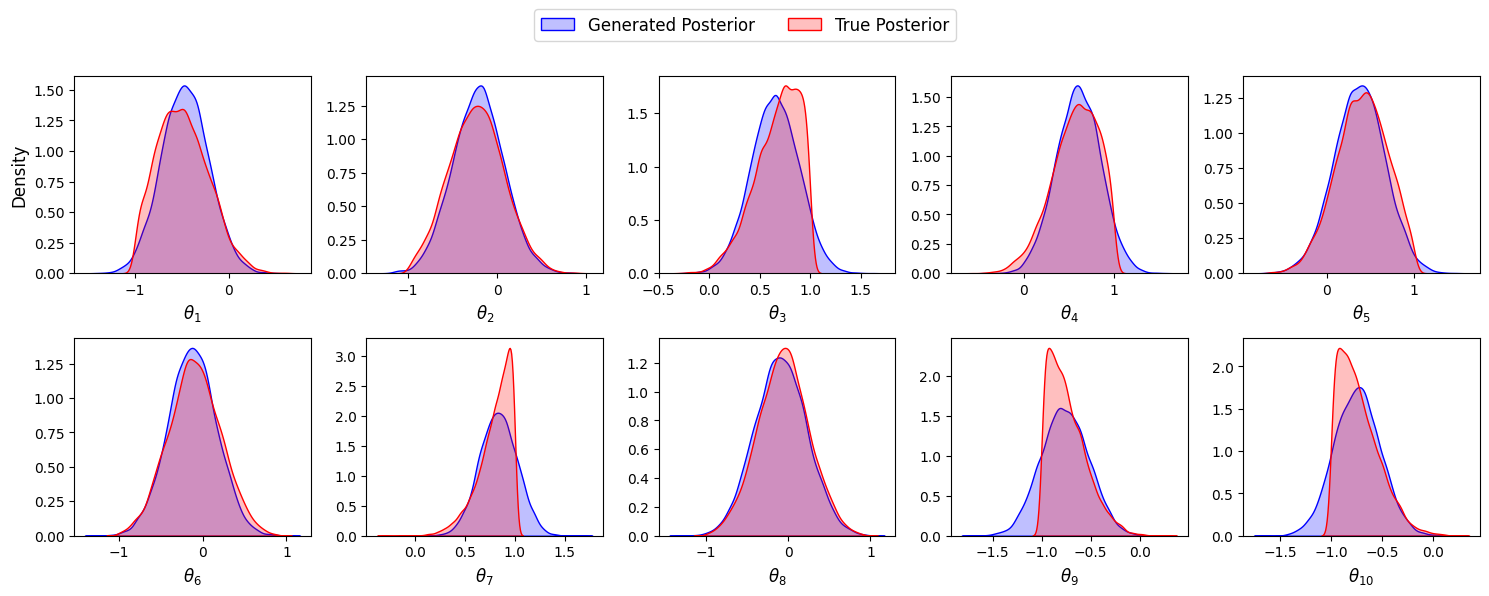

A dataset for gaussian_linear_uniform with 20000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 5
	Number of residual blocks: 4
	Hidden features: 32
	Theta dim: 10
	y dim: 10
Epoch [1/1000] - Train Loss: 14.5399 | Val Loss: 7.6402
Epoch [2/1000] - Train Loss: 7.1543 | Val Loss: 6.9013
Epoch [3/1000] - Train Loss: 6.8456 | Val Loss: 6.7174
Epoch [4/1000] - Train Loss: 6.6656 | Val Loss: 6.6026
Epoch [5/1000] - Train Loss: 6.5332 | Val Loss: 6.4921
Epoch [6/1000] - Train Loss: 6.4335 | Val Loss: 6.4032
Epoch [7/1000] - Train Loss: 6.3551 | Val Loss: 6.3501
Epoch [8/1000] - Train Loss: 6.3017 | Val Loss: 6.2847
Epoch [9/1000] - Train Loss: 6.2773 | Val Loss: 6.3126
Epoch [10/1000] - Train Loss: 6.2494 | Val Loss: 6.2649
Epoch [11/1000] - Train Loss: 6.2320 | Val Loss: 6.2726
Epoch [12/1000] - Train Loss: 6.2185 | Val Loss: 6.2587
Epoch [13/1

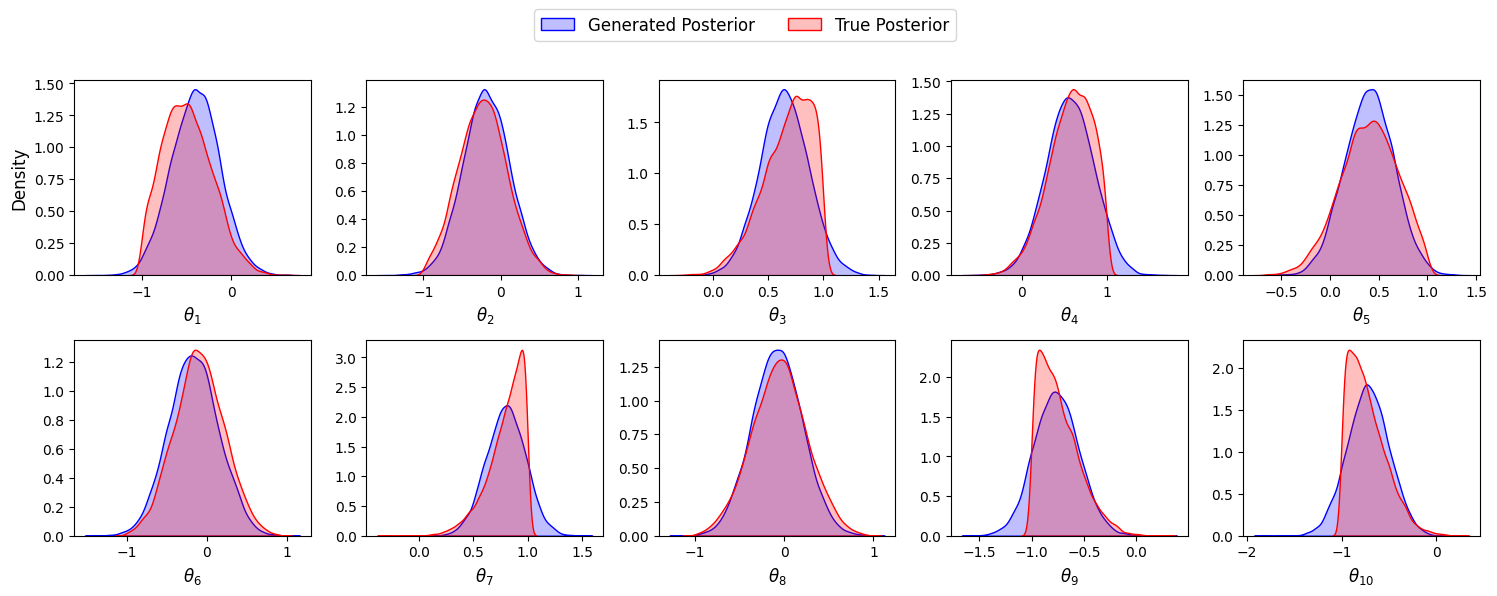

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\gaussian_linear_uniform\dataset_2_MAF_gaussian_linear_uniform_budget_20k.npz
A dataset for gaussian_linear_uniform with 20000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 5
	Number of residual blocks: 4
	Hidden features: 32
	Theta dim: 10
	y dim: 10
Epoch [1/1000] - Train Loss: 14.1698 | Val Loss: 8.0180
Epoch [2/1000] - Train Loss: 7.2958 | Val Loss: 6.8885
Epoch [3/1000] - Train Loss: 6.8563 | Val Loss: 6.7194
Epoch [4/1000] - Train Loss: 6.6811 | Val Loss: 6.6003
Epoch [5/1000] - Train Loss: 6.5691 | Val Loss: 6.5043
Epoch [6/1000] - Train Loss: 6.4635 | Val Loss: 6.4372
Epoch [7/1000] - Train Loss: 6.3976 | Val Loss: 6.3360
Epoch [8/1000] - Train Loss: 6.3305 | Val Loss: 6.3174
Epoch [9/1000] - Train Loss: 6.

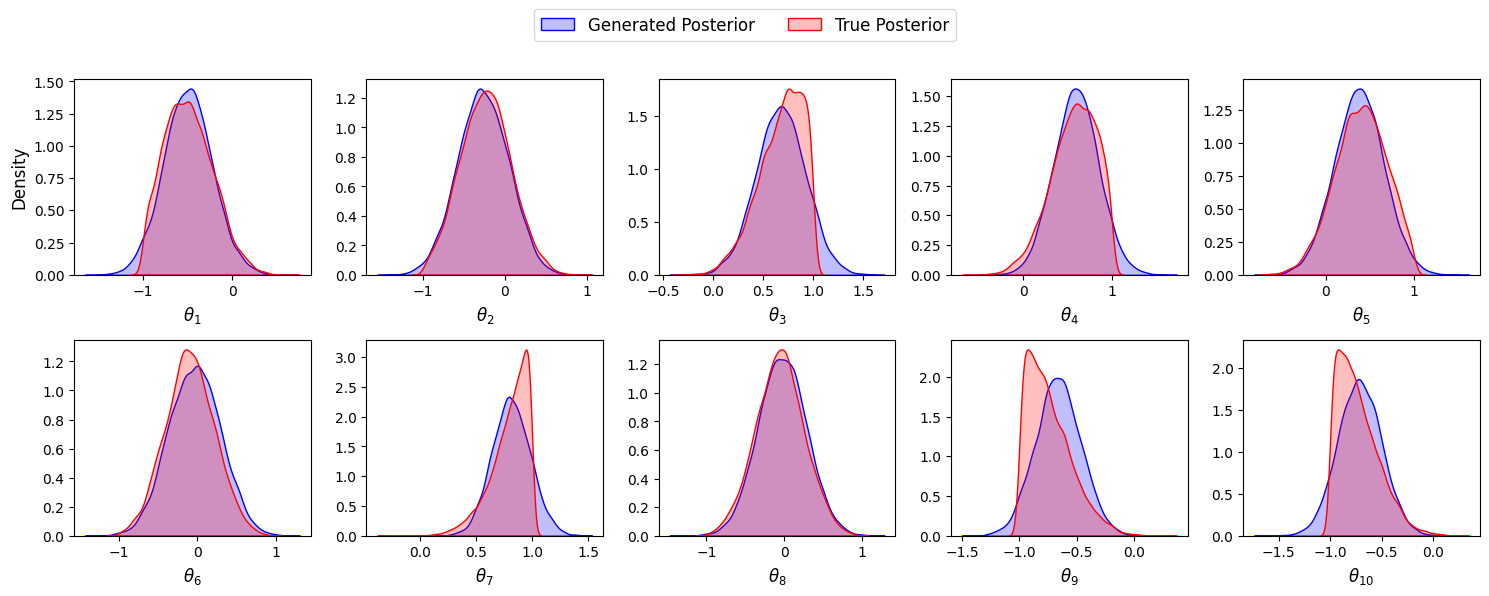

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\gaussian_linear_uniform\dataset_3_MAF_gaussian_linear_uniform_budget_20k.npz
A dataset for gaussian_linear_uniform with 20000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 5
	Number of residual blocks: 4
	Hidden features: 32
	Theta dim: 10
	y dim: 10
Epoch [1/1000] - Train Loss: 13.3930 | Val Loss: 7.3742
Epoch [2/1000] - Train Loss: 7.0765 | Val Loss: 6.9345
Epoch [3/1000] - Train Loss: 6.8385 | Val Loss: 6.7819
Epoch [4/1000] - Train Loss: 6.6929 | Val Loss: 6.6796
Epoch [5/1000] - Train Loss: 6.5629 | Val Loss: 6.6099
Epoch [6/1000] - Train Loss: 6.4853 | Val Loss: 6.4803
Epoch [7/1000] - Train Loss: 6.3859 | Val Loss: 6.4532
Epoch [8/1000] - Train Loss: 6.3255 | Val Loss: 6.4032
Epoch [9/1000] - Train Loss: 6.

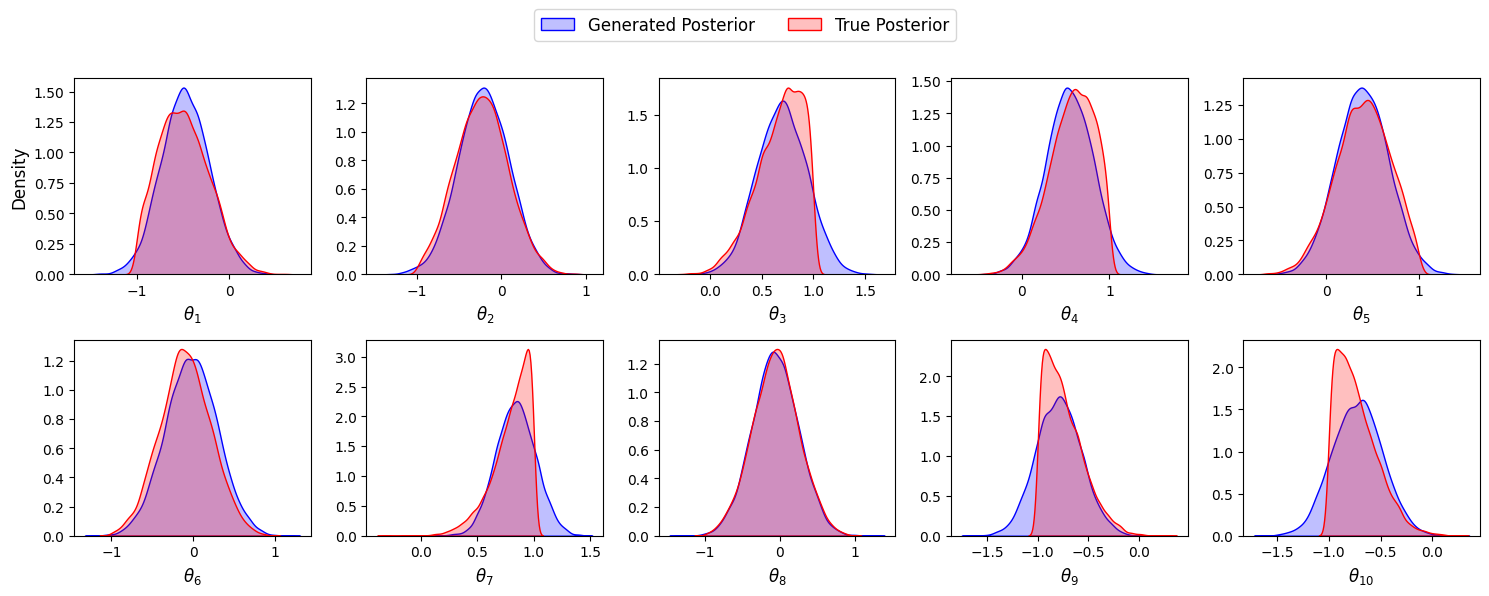

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\gaussian_linear_uniform\dataset_4_MAF_gaussian_linear_uniform_budget_20k.npz
A dataset for gaussian_linear_uniform with 20000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 5
	Number of residual blocks: 4
	Hidden features: 32
	Theta dim: 10
	y dim: 10
Epoch [1/1000] - Train Loss: 14.0021 | Val Loss: 7.6889
Epoch [2/1000] - Train Loss: 7.1552 | Val Loss: 6.9551
Epoch [3/1000] - Train Loss: 6.8437 | Val Loss: 6.8017
Epoch [4/1000] - Train Loss: 6.7169 | Val Loss: 6.6986
Epoch [5/1000] - Train Loss: 6.5928 | Val Loss: 6.5986
Epoch [6/1000] - Train Loss: 6.5096 | Val Loss: 6.4802
Epoch [7/1000] - Train Loss: 6.4158 | Val Loss: 6.4218
Epoch [8/1000] - Train Loss: 6.3556 | Val Loss: 6.3692
Epoch [9/1000] - Train Loss: 6.

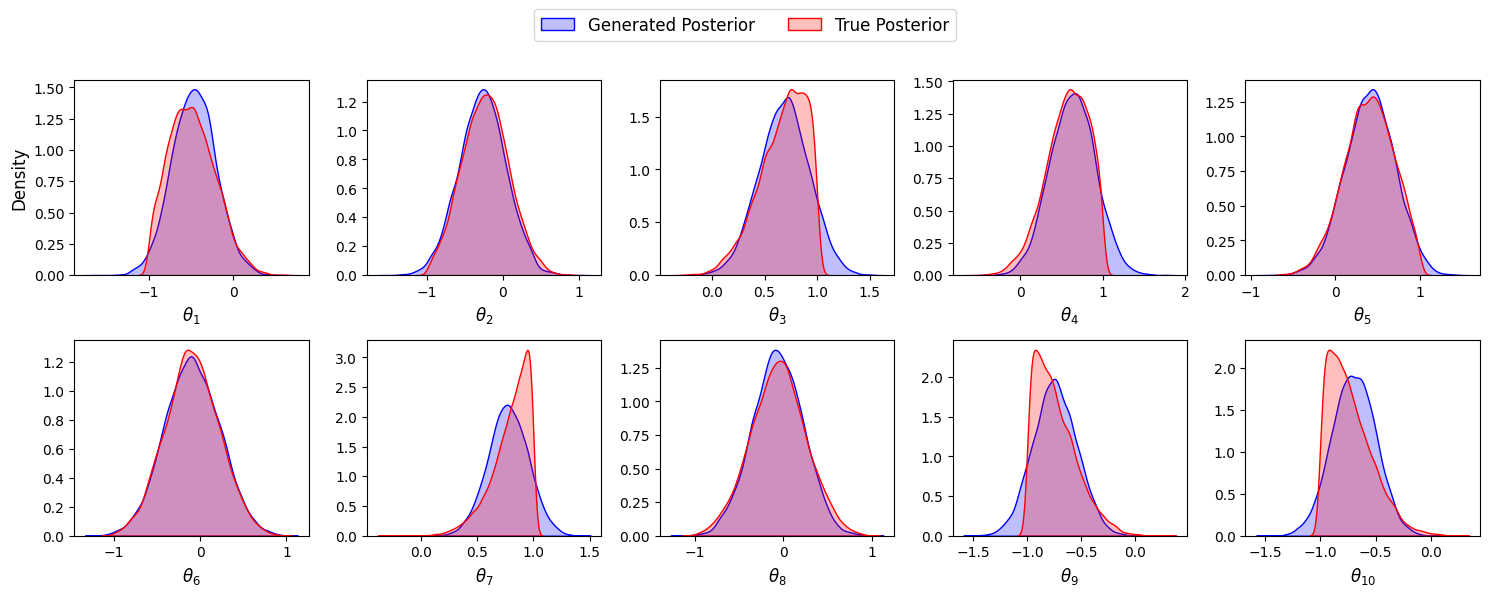

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\gaussian_linear_uniform\dataset_5_MAF_gaussian_linear_uniform_budget_20k.npz
A dataset for gaussian_linear_uniform with 10000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 5
	Number of residual blocks: 4
	Hidden features: 32
	Theta dim: 10
	y dim: 10
Epoch [1/1000] - Train Loss: 19.8033 | Val Loss: 12.0754
Epoch [2/1000] - Train Loss: 9.4246 | Val Loss: 7.8515
Epoch [3/1000] - Train Loss: 7.4648 | Val Loss: 7.0802
Epoch [4/1000] - Train Loss: 7.0571 | Val Loss: 6.8965
Epoch [5/1000] - Train Loss: 6.9298 | Val Loss: 6.8187
Epoch [6/1000] - Train Loss: 6.8202 | Val Loss: 6.7428
Epoch [7/1000] - Train Loss: 6.7402 | Val Loss: 6.6695
Epoch [8/1000] - Train Loss: 6.6902 | Val Loss: 6.6064
Epoch [9/1000] - Train Loss: 6

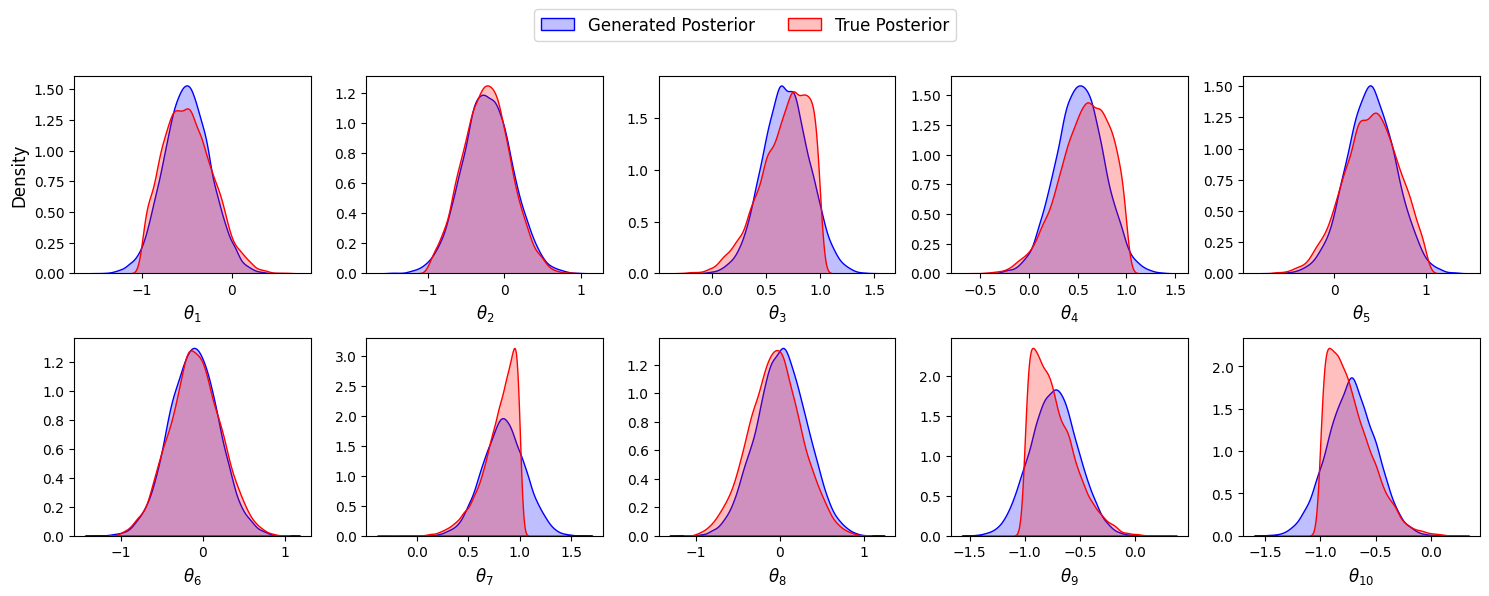

A dataset for gaussian_linear_uniform with 10000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 5
	Number of residual blocks: 4
	Hidden features: 32
	Theta dim: 10
	y dim: 10
Epoch [1/1000] - Train Loss: 19.5339 | Val Loss: 11.3640
Epoch [2/1000] - Train Loss: 8.9718 | Val Loss: 7.7301
Epoch [3/1000] - Train Loss: 7.3150 | Val Loss: 7.1267
Epoch [4/1000] - Train Loss: 7.0662 | Val Loss: 7.0313
Epoch [5/1000] - Train Loss: 6.9455 | Val Loss: 6.8973
Epoch [6/1000] - Train Loss: 6.8456 | Val Loss: 6.8630
Epoch [7/1000] - Train Loss: 6.7632 | Val Loss: 6.7969
Epoch [8/1000] - Train Loss: 6.7129 | Val Loss: 6.7566
Epoch [9/1000] - Train Loss: 6.6612 | Val Loss: 6.6829
Epoch [10/1000] - Train Loss: 6.6036 | Val Loss: 6.6408
Epoch [11/1000] - Train Loss: 6.5515 | Val Loss: 6.6670
Epoch [12/1000] - Train Loss: 6.5156 | Val Loss: 6.5802
Epoch [13/

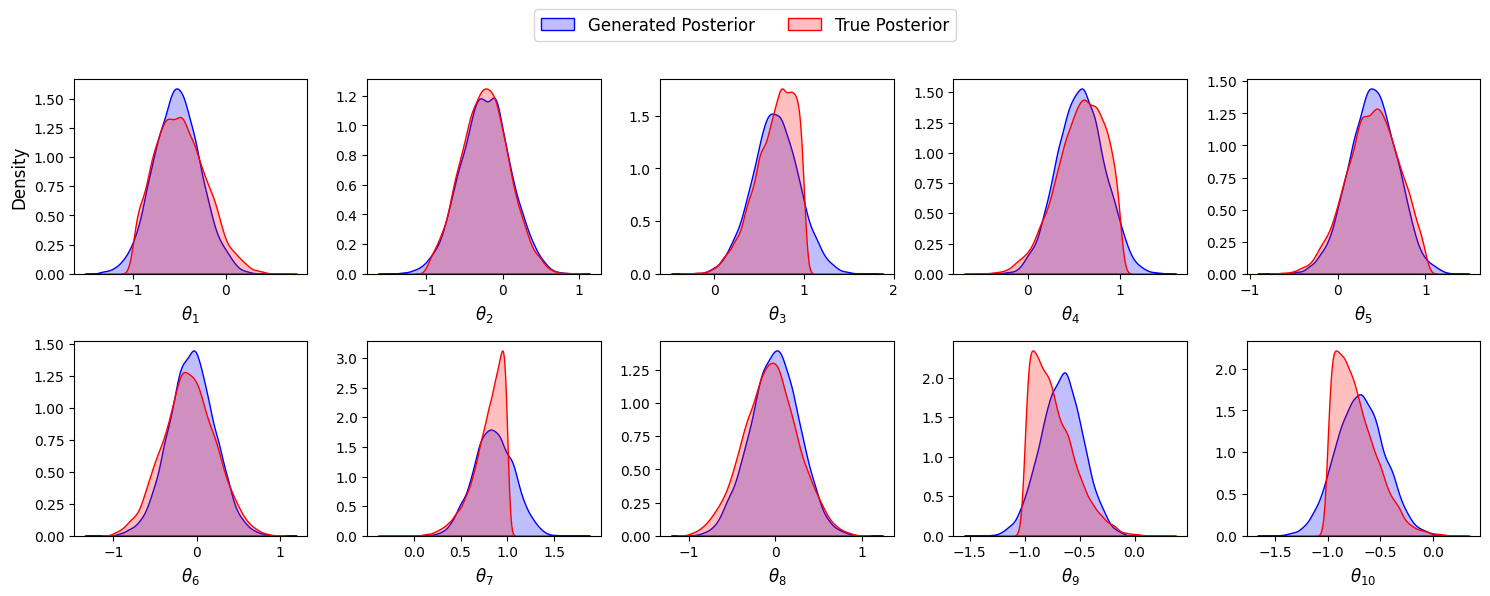

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\gaussian_linear_uniform\dataset_2_MAF_gaussian_linear_uniform_budget_10k.npz
A dataset for gaussian_linear_uniform with 10000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 5
	Number of residual blocks: 4
	Hidden features: 32
	Theta dim: 10
	y dim: 10
Epoch [1/1000] - Train Loss: 20.9962 | Val Loss: 12.8034
Epoch [2/1000] - Train Loss: 9.6490 | Val Loss: 7.9629
Epoch [3/1000] - Train Loss: 7.4677 | Val Loss: 7.1136
Epoch [4/1000] - Train Loss: 7.0485 | Val Loss: 6.9193
Epoch [5/1000] - Train Loss: 6.9171 | Val Loss: 6.8267
Epoch [6/1000] - Train Loss: 6.8249 | Val Loss: 6.7552
Epoch [7/1000] - Train Loss: 6.7374 | Val Loss: 6.7032
Epoch [8/1000] - Train Loss: 6.6463 | Val Loss: 6.6248
Epoch [9/1000] - Train Loss: 6

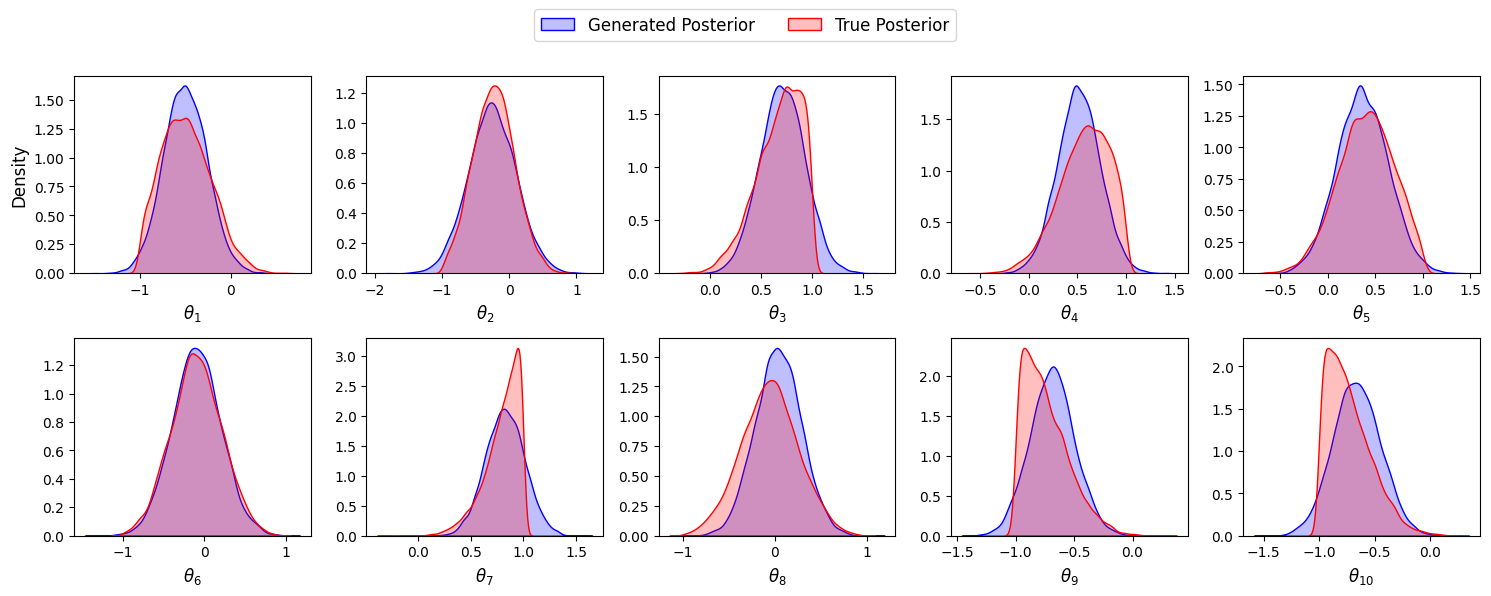

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\gaussian_linear_uniform\dataset_3_MAF_gaussian_linear_uniform_budget_10k.npz
A dataset for gaussian_linear_uniform with 10000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 5
	Number of residual blocks: 4
	Hidden features: 32
	Theta dim: 10
	y dim: 10
Epoch [1/1000] - Train Loss: 20.8961 | Val Loss: 12.1677
Epoch [2/1000] - Train Loss: 9.0830 | Val Loss: 7.6798
Epoch [3/1000] - Train Loss: 7.3445 | Val Loss: 7.1746
Epoch [4/1000] - Train Loss: 7.0788 | Val Loss: 7.0249
Epoch [5/1000] - Train Loss: 6.9169 | Val Loss: 6.9145
Epoch [6/1000] - Train Loss: 6.8303 | Val Loss: 6.8358
Epoch [7/1000] - Train Loss: 6.7651 | Val Loss: 6.7988
Epoch [8/1000] - Train Loss: 6.6913 | Val Loss: 6.7362
Epoch [9/1000] - Train Loss: 6

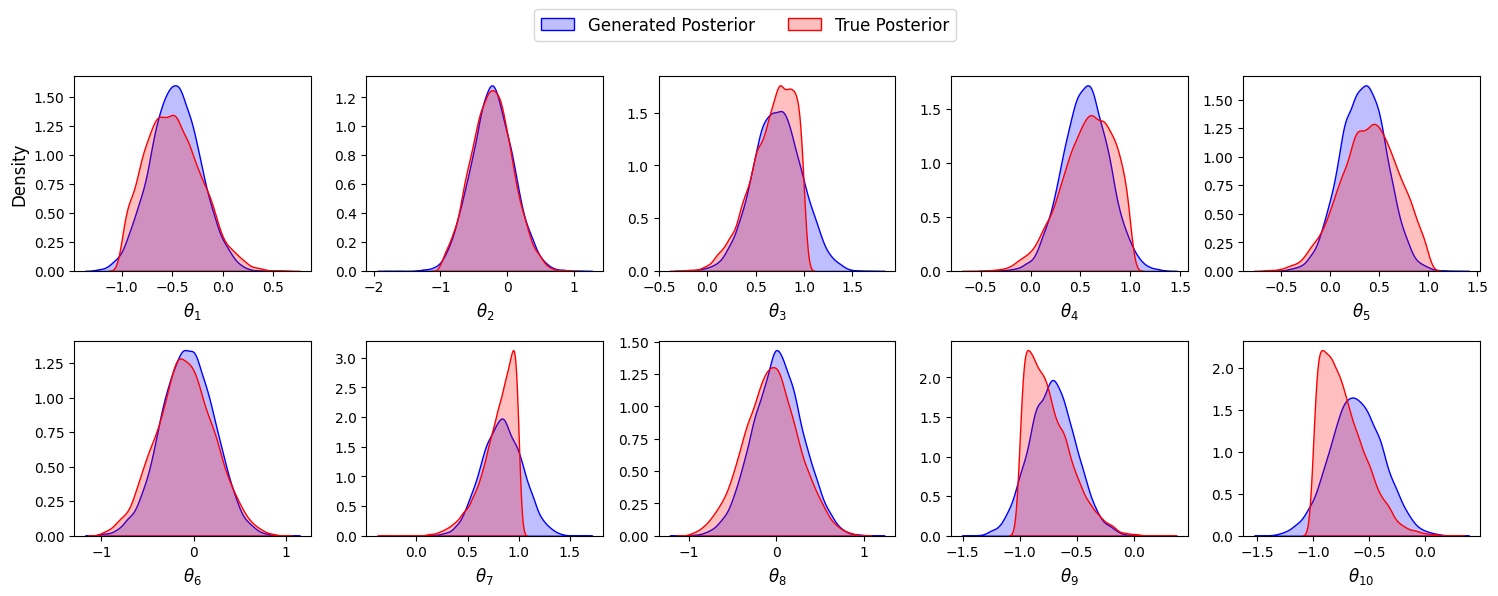

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\gaussian_linear_uniform\dataset_4_MAF_gaussian_linear_uniform_budget_10k.npz
A dataset for gaussian_linear_uniform with 10000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 5
	Number of residual blocks: 4
	Hidden features: 32
	Theta dim: 10
	y dim: 10
Epoch [1/1000] - Train Loss: 20.5000 | Val Loss: 13.1960
Epoch [2/1000] - Train Loss: 10.8740 | Val Loss: 9.2849
Epoch [3/1000] - Train Loss: 8.5038 | Val Loss: 7.9211
Epoch [4/1000] - Train Loss: 7.5835 | Val Loss: 7.2965
Epoch [5/1000] - Train Loss: 7.1008 | Val Loss: 6.9597
Epoch [6/1000] - Train Loss: 6.8984 | Val Loss: 6.8964
Epoch [7/1000] - Train Loss: 6.8140 | Val Loss: 6.8144
Epoch [8/1000] - Train Loss: 6.7189 | Val Loss: 6.7343
Epoch [9/1000] - Train Loss: 

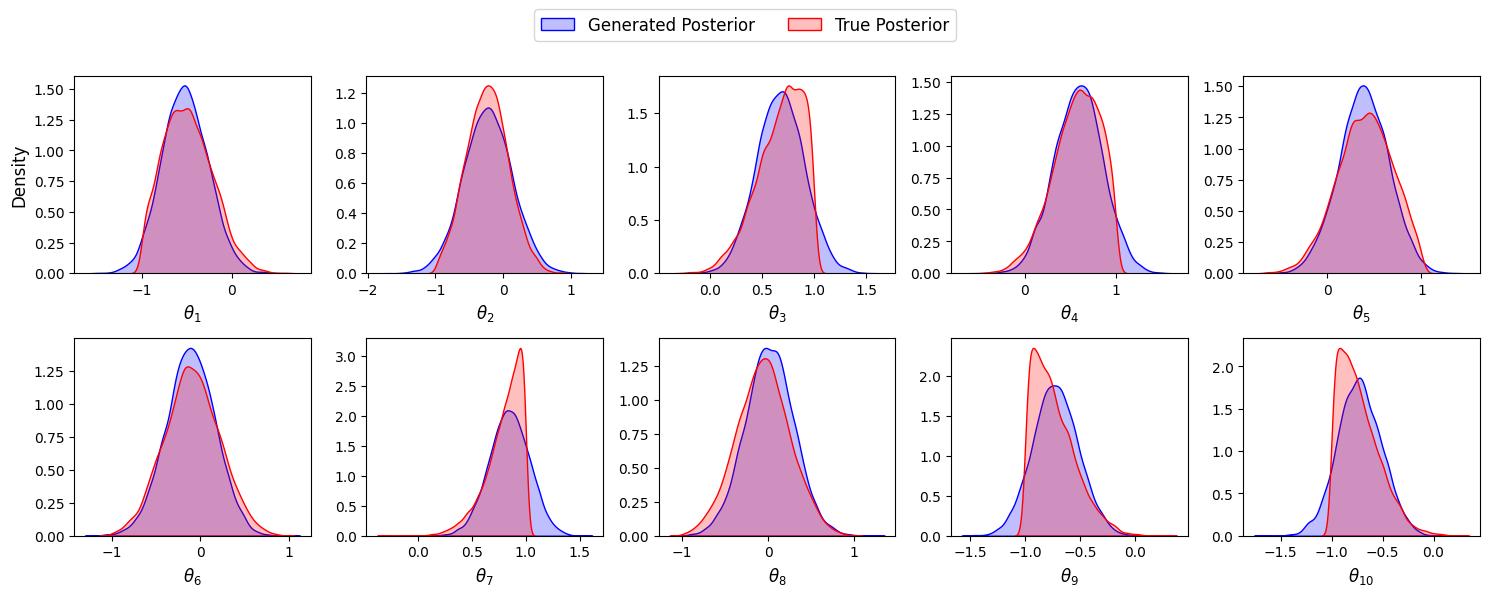

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\gaussian_linear_uniform\dataset_5_MAF_gaussian_linear_uniform_budget_10k.npz
A dataset for gaussian_linear_uniform with 5000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 5
	Number of residual blocks: 4
	Hidden features: 32
	Theta dim: 10
	y dim: 10
Epoch [1/1000] - Train Loss: 23.4050 | Val Loss: 19.1282
Epoch [2/1000] - Train Loss: 14.4221 | Val Loss: 10.9760
Epoch [3/1000] - Train Loss: 9.4406 | Val Loss: 8.5037
Epoch [4/1000] - Train Loss: 7.9241 | Val Loss: 7.5497
Epoch [5/1000] - Train Loss: 7.3337 | Val Loss: 7.2294
Epoch [6/1000] - Train Loss: 7.0823 | Val Loss: 7.1060
Epoch [7/1000] - Train Loss: 6.9608 | Val Loss: 7.0290
Epoch [8/1000] - Train Loss: 6.8899 | Val Loss: 6.9393
Epoch [9/1000] - Train Loss: 

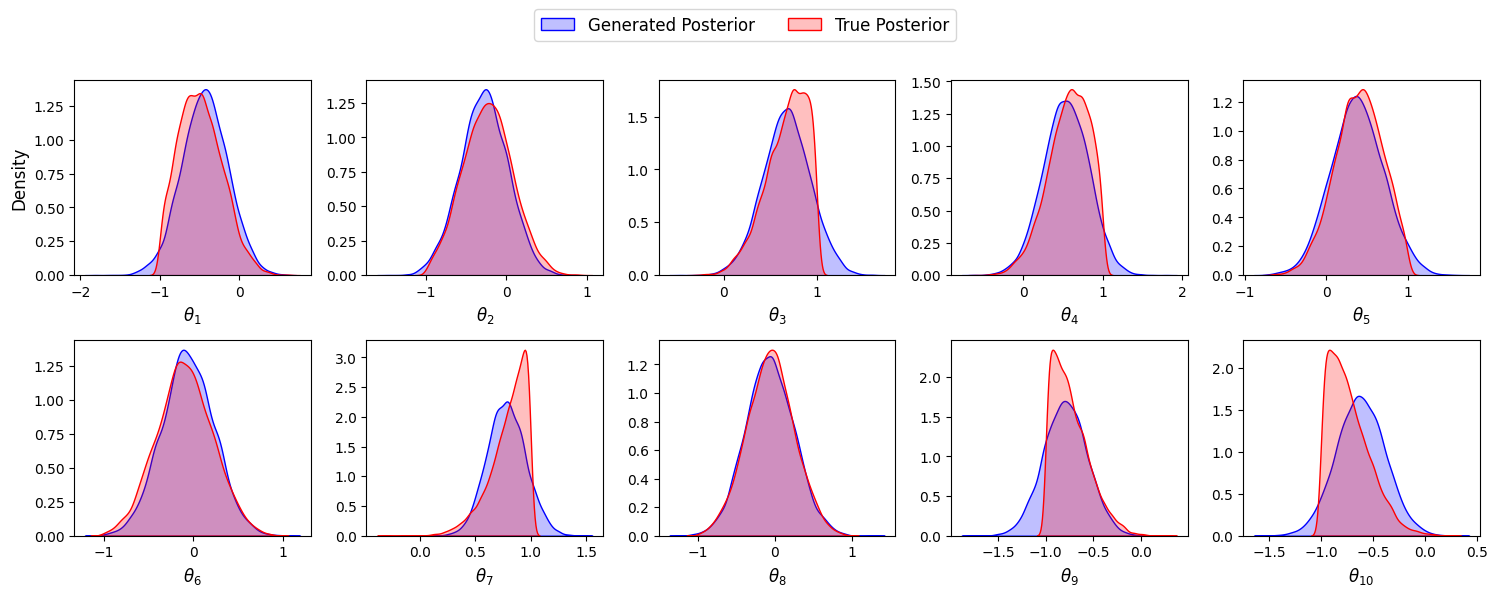

A dataset for gaussian_linear_uniform with 5000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 5
	Number of residual blocks: 4
	Hidden features: 32
	Theta dim: 10
	y dim: 10
Epoch [1/1000] - Train Loss: 23.2942 | Val Loss: 18.9083
Epoch [2/1000] - Train Loss: 14.9629 | Val Loss: 12.1509
Epoch [3/1000] - Train Loss: 10.3265 | Val Loss: 9.1280
Epoch [4/1000] - Train Loss: 8.4931 | Val Loss: 8.0461
Epoch [5/1000] - Train Loss: 7.7031 | Val Loss: 7.5921
Epoch [6/1000] - Train Loss: 7.3373 | Val Loss: 7.2985
Epoch [7/1000] - Train Loss: 7.0760 | Val Loss: 7.1414
Epoch [8/1000] - Train Loss: 6.9215 | Val Loss: 7.0107
Epoch [9/1000] - Train Loss: 6.8566 | Val Loss: 6.9798
Epoch [10/1000] - Train Loss: 6.8020 | Val Loss: 6.9349
Epoch [11/1000] - Train Loss: 6.7341 | Val Loss: 6.9254
Epoch [12/1000] - Train Loss: 6.7216 | Val Loss: 6.9266
Epoch [1

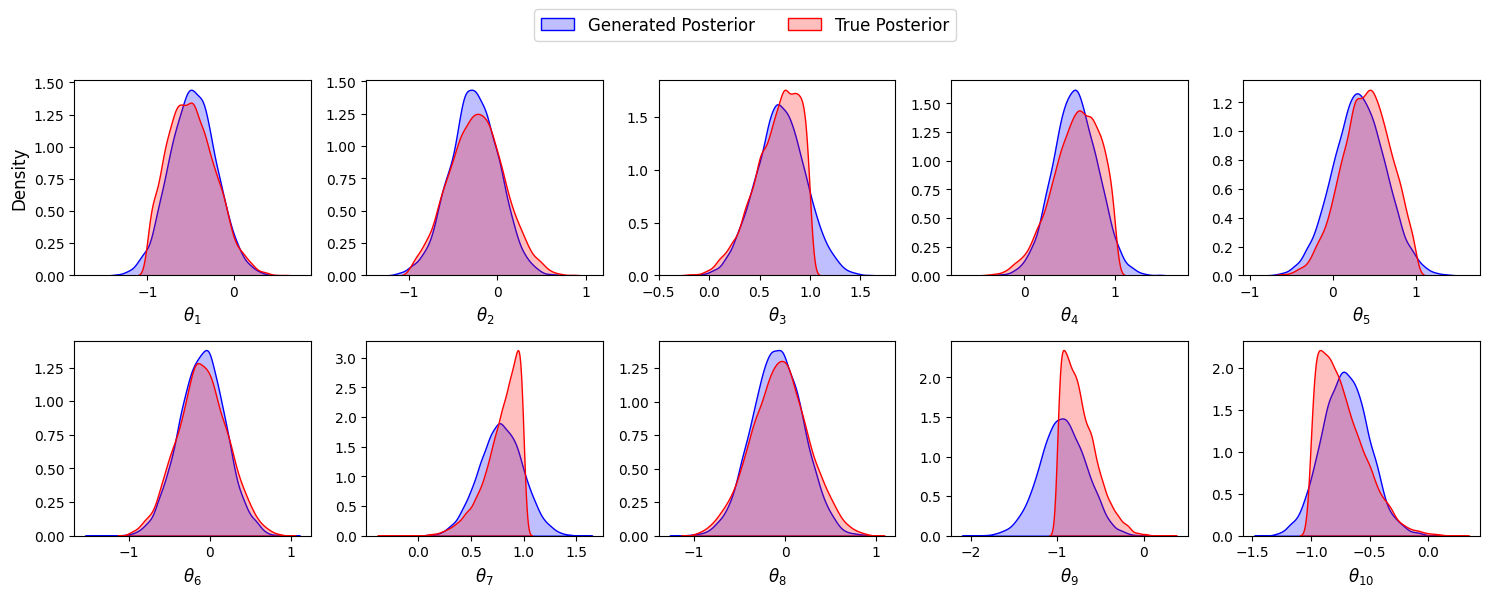

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\gaussian_linear_uniform\dataset_2_MAF_gaussian_linear_uniform_budget_5k.npz
A dataset for gaussian_linear_uniform with 5000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 5
	Number of residual blocks: 4
	Hidden features: 32
	Theta dim: 10
	y dim: 10
Epoch [1/1000] - Train Loss: 22.7238 | Val Loss: 18.2530
Epoch [2/1000] - Train Loss: 13.9394 | Val Loss: 10.9842
Epoch [3/1000] - Train Loss: 9.4140 | Val Loss: 8.4426
Epoch [4/1000] - Train Loss: 7.8718 | Val Loss: 7.6286
Epoch [5/1000] - Train Loss: 7.2837 | Val Loss: 7.2697
Epoch [6/1000] - Train Loss: 7.0336 | Val Loss: 7.1433
Epoch [7/1000] - Train Loss: 6.9271 | Val Loss: 7.0858
Epoch [8/1000] - Train Loss: 6.8525 | Val Loss: 7.0335
Epoch [9/1000] - Train Loss: 6

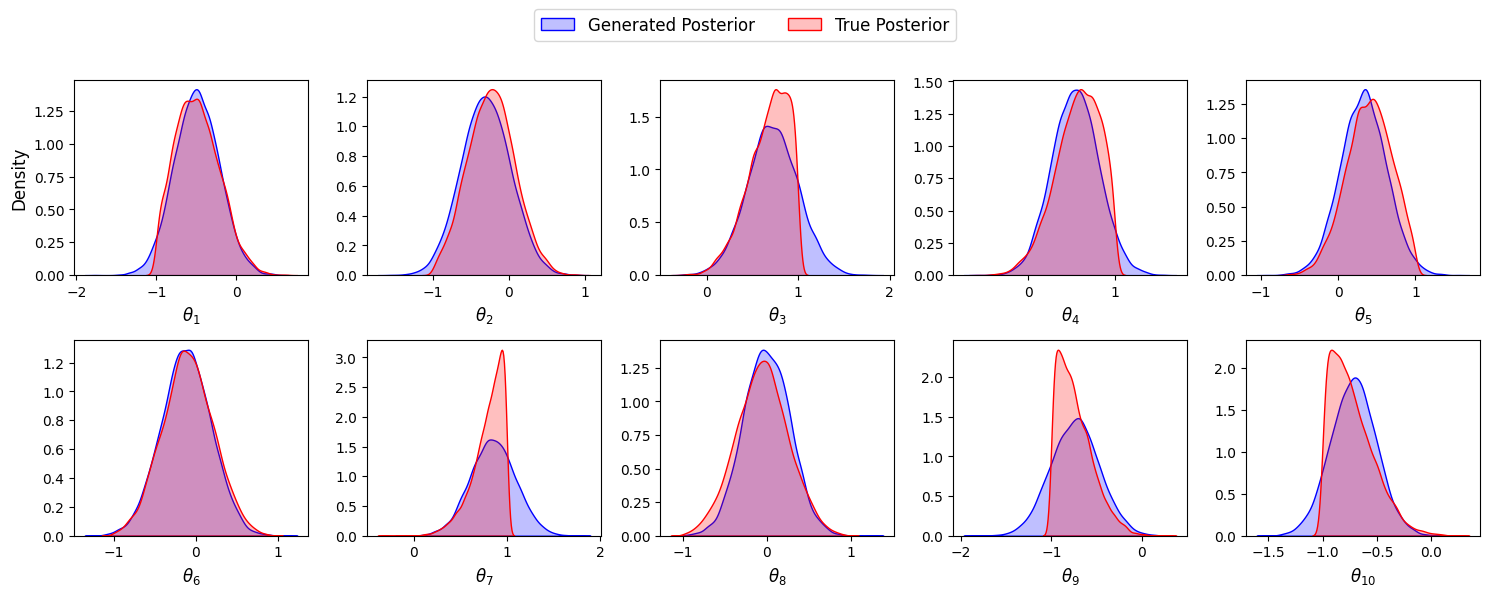

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\gaussian_linear_uniform\dataset_3_MAF_gaussian_linear_uniform_budget_5k.npz
A dataset for gaussian_linear_uniform with 5000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 5
	Number of residual blocks: 4
	Hidden features: 32
	Theta dim: 10
	y dim: 10
Epoch [1/1000] - Train Loss: 24.1557 | Val Loss: 19.4221
Epoch [2/1000] - Train Loss: 14.4206 | Val Loss: 10.7845
Epoch [3/1000] - Train Loss: 9.2852 | Val Loss: 8.1954
Epoch [4/1000] - Train Loss: 7.8274 | Val Loss: 7.4419
Epoch [5/1000] - Train Loss: 7.2737 | Val Loss: 7.1717
Epoch [6/1000] - Train Loss: 7.1035 | Val Loss: 7.0268
Epoch [7/1000] - Train Loss: 6.9639 | Val Loss: 6.9771
Epoch [8/1000] - Train Loss: 6.8940 | Val Loss: 6.8921
Epoch [9/1000] - Train Loss: 6

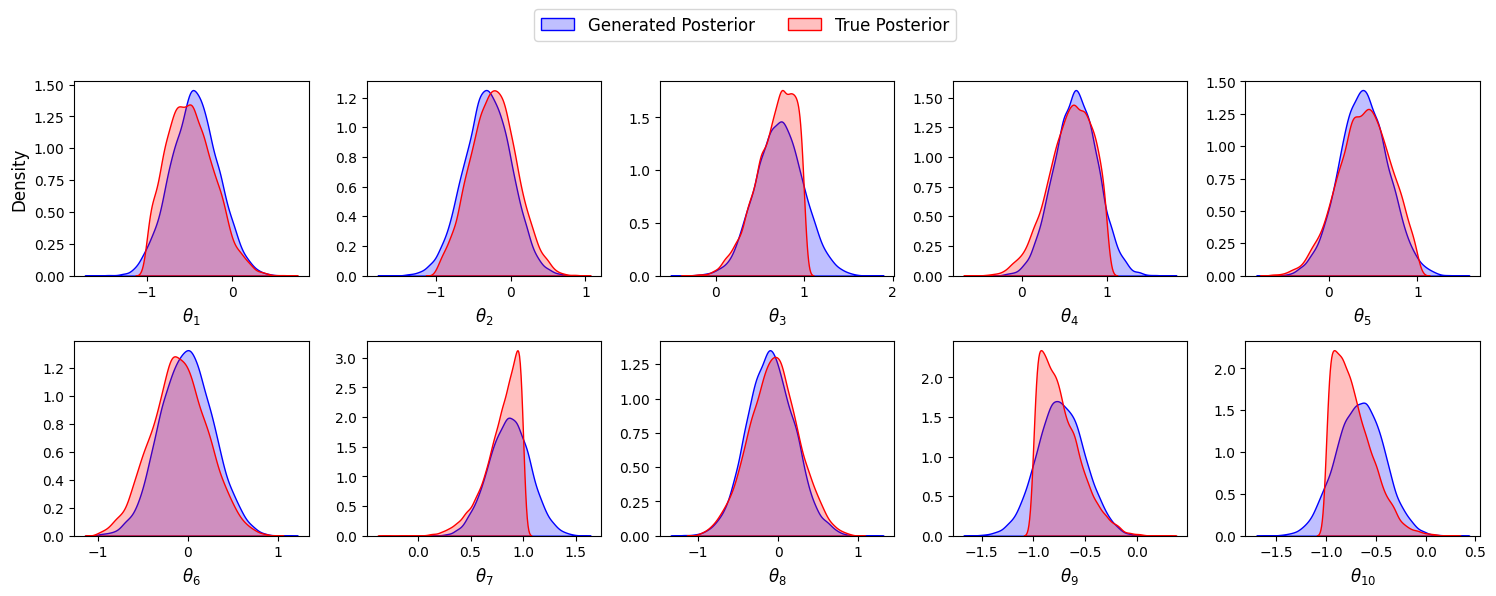

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\gaussian_linear_uniform\dataset_4_MAF_gaussian_linear_uniform_budget_5k.npz
A dataset for gaussian_linear_uniform with 5000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 5
	Number of residual blocks: 4
	Hidden features: 32
	Theta dim: 10
	y dim: 10
Epoch [1/1000] - Train Loss: 25.1680 | Val Loss: 20.6707
Epoch [2/1000] - Train Loss: 15.5165 | Val Loss: 11.3360
Epoch [3/1000] - Train Loss: 9.4580 | Val Loss: 8.0779
Epoch [4/1000] - Train Loss: 7.6580 | Val Loss: 7.2177
Epoch [5/1000] - Train Loss: 7.2396 | Val Loss: 7.0257
Epoch [6/1000] - Train Loss: 7.0786 | Val Loss: 6.9409
Epoch [7/1000] - Train Loss: 6.9696 | Val Loss: 6.8536
Epoch [8/1000] - Train Loss: 6.9021 | Val Loss: 6.8488
Epoch [9/1000] - Train Loss: 6

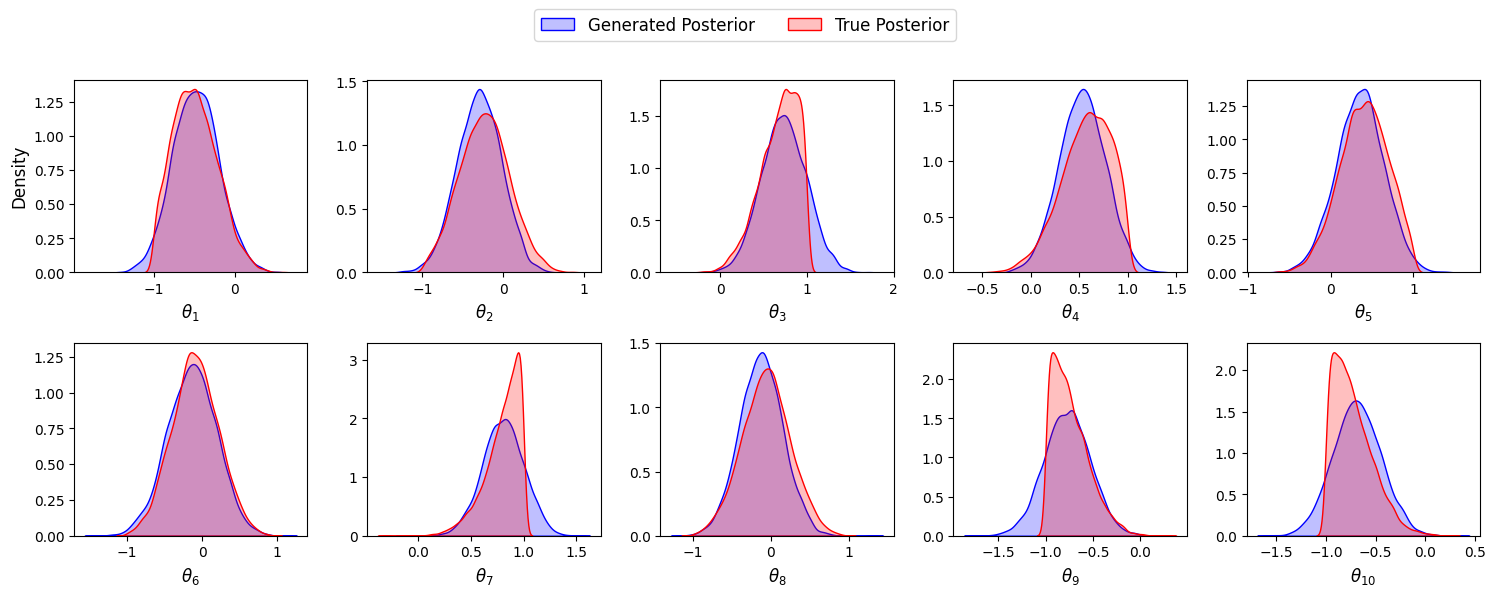

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\gaussian_linear_uniform\dataset_5_MAF_gaussian_linear_uniform_budget_5k.npz
A dataset for two_moons with 20000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 10
	Number of residual blocks: 2
	Hidden features: 16
	Theta dim: 2
	y dim: 2
Epoch [1/1000] - Train Loss: 0.1695 | Val Loss: -1.7258
Epoch [2/1000] - Train Loss: -2.2582 | Val Loss: -2.7186
Epoch [3/1000] - Train Loss: -2.7244 | Val Loss: -2.8896
Epoch [4/1000] - Train Loss: -2.9227 | Val Loss: -2.1574
Epoch [5/1000] - Train Loss: -3.1567 | Val Loss: -3.2390
Epoch [6/1000] - Train Loss: -3.2072 | Val Loss: -3.4990
Epoch [7/1000] - Train Loss: -3.2524 | Val Loss: -3.4339
Epoch [8/1000] - Train Loss: -3.3927 | Val Loss: -3.0992
Epoch [9/1000] - Train Loss: -3.3

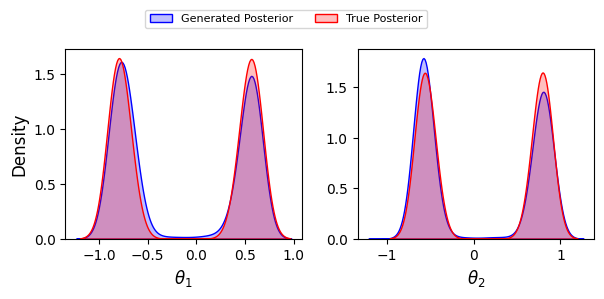

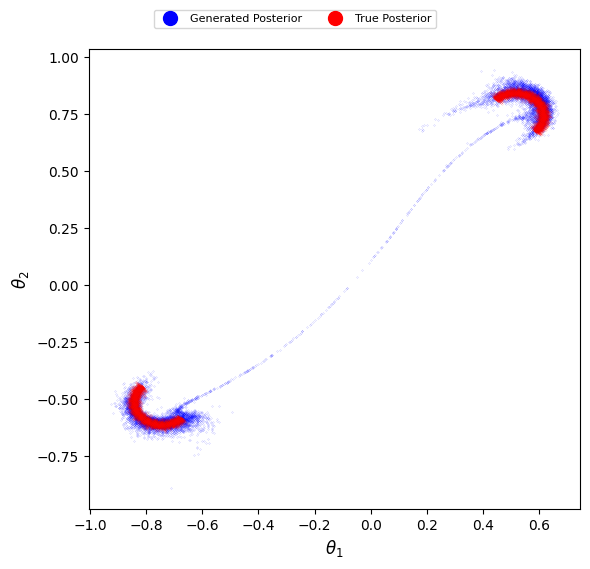

<Figure size 640x480 with 0 Axes>

A dataset for two_moons with 20000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 10
	Number of residual blocks: 2
	Hidden features: 16
	Theta dim: 2
	y dim: 2
Epoch [1/1000] - Train Loss: 0.1375 | Val Loss: -2.6516
Epoch [2/1000] - Train Loss: -2.3401 | Val Loss: -2.8928
Epoch [3/1000] - Train Loss: -2.5433 | Val Loss: -2.9070
Epoch [4/1000] - Train Loss: -2.7114 | Val Loss: -2.8333
Epoch [5/1000] - Train Loss: -2.9623 | Val Loss: -3.2513
Epoch [6/1000] - Train Loss: -2.9999 | Val Loss: -3.1378
Epoch [7/1000] - Train Loss: -2.9810 | Val Loss: -3.3759
Epoch [8/1000] - Train Loss: -3.1259 | Val Loss: -3.3834
Epoch [9/1000] - Train Loss: -3.1576 | Val Loss: -3.1311
Epoch [10/1000] - Train Loss: -2.9293 | Val Loss: -3.2947
Epoch [11/1000] - Train Loss: -3.2224 | Val Loss: -3.6674
Epoch [12/1000] - Train Loss: -3.2745 | Val Loss: -3.5439
Epoc

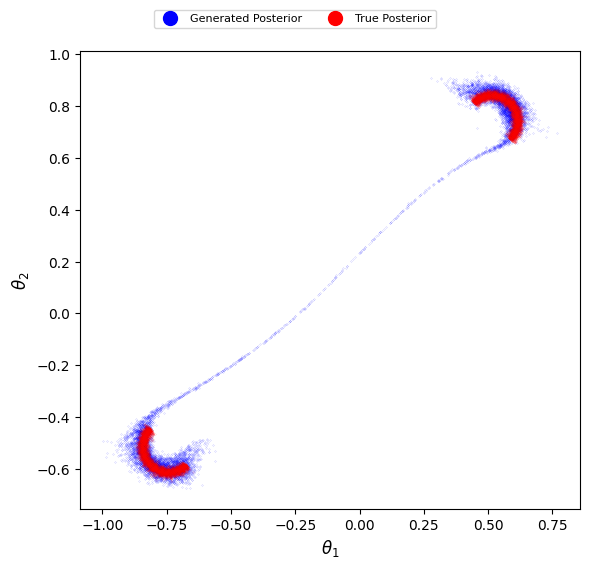

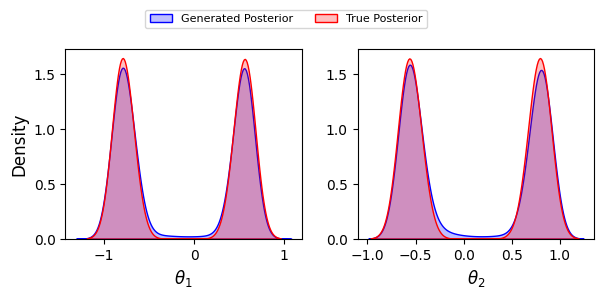

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\two_moons\dataset_2_MAF_two_moons_budget_20k.npz
A dataset for two_moons with 20000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 10
	Number of residual blocks: 2
	Hidden features: 16
	Theta dim: 2
	y dim: 2
Epoch [1/1000] - Train Loss: 0.5139 | Val Loss: -2.4054
Epoch [2/1000] - Train Loss: -2.4981 | Val Loss: -2.9549
Epoch [3/1000] - Train Loss: -2.8196 | Val Loss: -2.6899
Epoch [4/1000] - Train Loss: -2.9328 | Val Loss: -3.1299
Epoch [5/1000] - Train Loss: -3.0191 | Val Loss: -3.2315
Epoch [6/1000] - Train Loss: -3.1195 | Val Loss: -3.4844
Epoch [7/1000] - Train Loss: -3.1652 | Val Loss: -3.5965
Epoch [8/1000] - Train Loss: -3.1264 | Val Loss: -2.8420
Epoch [9/1000] - Train Loss: -3.2448 | Val Loss: -2.6496
Epo

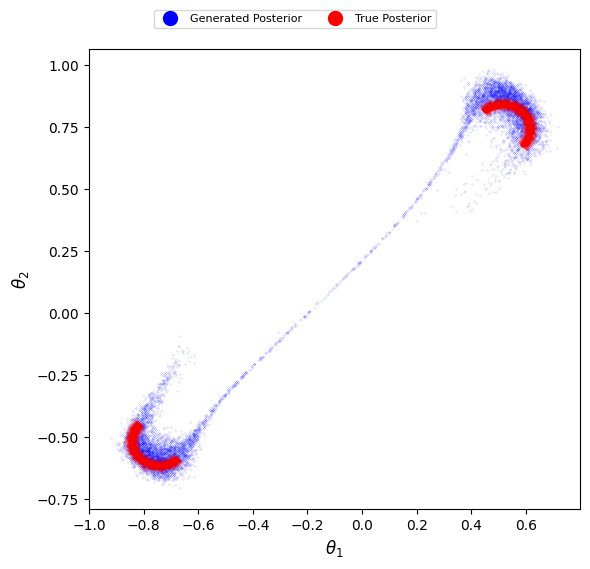

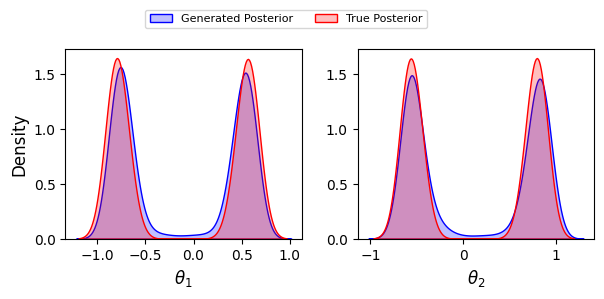

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\two_moons\dataset_3_MAF_two_moons_budget_20k.npz
A dataset for two_moons with 20000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 10
	Number of residual blocks: 2
	Hidden features: 16
	Theta dim: 2
	y dim: 2
Epoch [1/1000] - Train Loss: 0.4746 | Val Loss: -2.4226
Epoch [2/1000] - Train Loss: -2.3153 | Val Loss: -2.9310
Epoch [3/1000] - Train Loss: -2.6627 | Val Loss: -2.8265
Epoch [4/1000] - Train Loss: -2.8488 | Val Loss: -3.2530
Epoch [5/1000] - Train Loss: -2.9708 | Val Loss: -3.2978
Epoch [6/1000] - Train Loss: -3.0033 | Val Loss: -3.1330
Epoch [7/1000] - Train Loss: -3.1181 | Val Loss: -3.3983
Epoch [8/1000] - Train Loss: -3.2700 | Val Loss: -3.0822
Epoch [9/1000] - Train Loss: -3.1933 | Val Loss: -3.5504
Epo

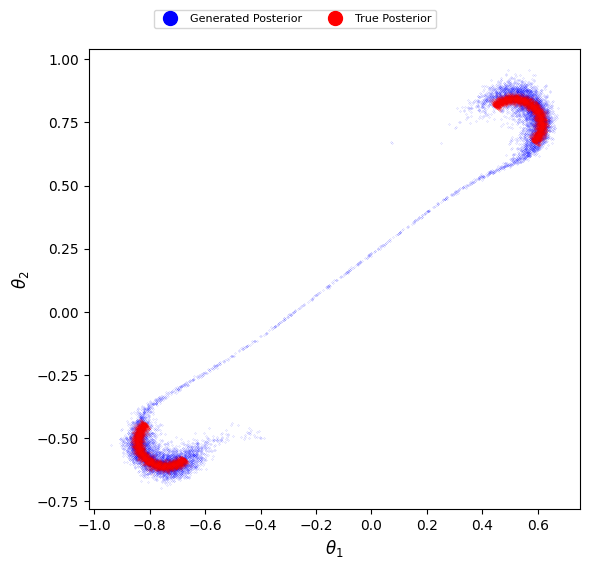

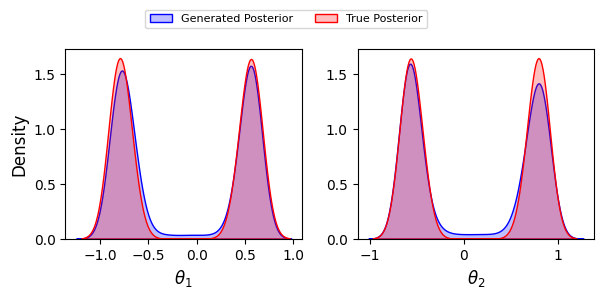

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\two_moons\dataset_4_MAF_two_moons_budget_20k.npz
A dataset for two_moons with 20000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 10
	Number of residual blocks: 2
	Hidden features: 16
	Theta dim: 2
	y dim: 2
Epoch [1/1000] - Train Loss: -0.4746 | Val Loss: -2.8412
Epoch [2/1000] - Train Loss: -2.5924 | Val Loss: -2.7967
Epoch [3/1000] - Train Loss: -2.8122 | Val Loss: -3.2326
Epoch [4/1000] - Train Loss: -2.9923 | Val Loss: -3.1945
Epoch [5/1000] - Train Loss: -3.0346 | Val Loss: -3.4332
Epoch [6/1000] - Train Loss: -3.1590 | Val Loss: -3.4580
Epoch [7/1000] - Train Loss: -3.2139 | Val Loss: -3.5698
Epoch [8/1000] - Train Loss: -3.2976 | Val Loss: -3.0506
Epoch [9/1000] - Train Loss: -3.1538 | Val Loss: -3.0781
Ep

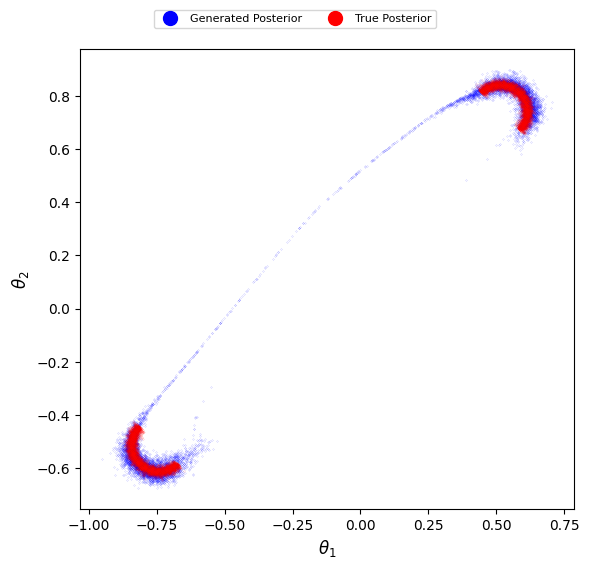

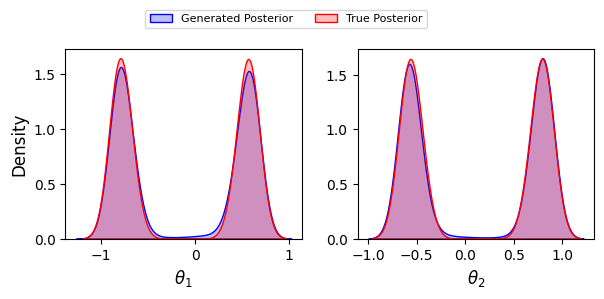

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\two_moons\dataset_5_MAF_two_moons_budget_20k.npz
A dataset for two_moons with 10000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 10
	Number of residual blocks: 2
	Hidden features: 16
	Theta dim: 2
	y dim: 2
Epoch [1/1000] - Train Loss: 2.3022 | Val Loss: -1.1223
Epoch [2/1000] - Train Loss: -1.5548 | Val Loss: -2.1837
Epoch [3/1000] - Train Loss: -2.1243 | Val Loss: -2.4977
Epoch [4/1000] - Train Loss: -2.4014 | Val Loss: -2.5693
Epoch [5/1000] - Train Loss: -2.3922 | Val Loss: -2.7046
Epoch [6/1000] - Train Loss: -2.5520 | Val Loss: -2.6246
Epoch [7/1000] - Train Loss: -2.6635 | Val Loss: -2.7809
Epoch [8/1000] - Train Loss: -2.6850 | Val Loss: -3.0623
Epoch [9/1000] - Train Loss: -2.8890 | Val Loss: -3.2559
Epo

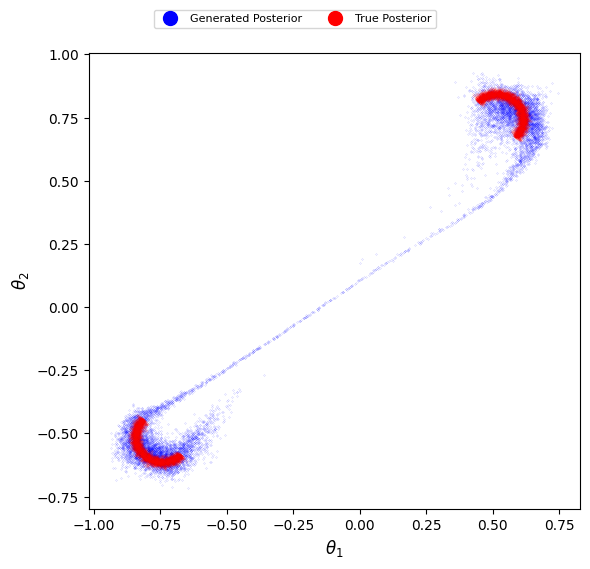

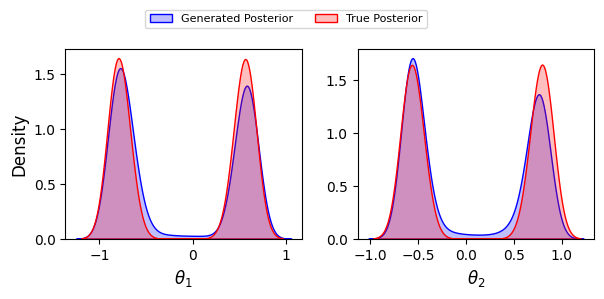

A dataset for two_moons with 10000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 10
	Number of residual blocks: 2
	Hidden features: 16
	Theta dim: 2
	y dim: 2
Epoch [1/1000] - Train Loss: 3.6636 | Val Loss: 0.9269
Epoch [2/1000] - Train Loss: 0.4351 | Val Loss: -0.4631
Epoch [3/1000] - Train Loss: -0.7457 | Val Loss: -1.5573
Epoch [4/1000] - Train Loss: -1.1817 | Val Loss: -1.9750
Epoch [5/1000] - Train Loss: -2.0286 | Val Loss: -2.5931
Epoch [6/1000] - Train Loss: -2.3600 | Val Loss: -2.8469
Epoch [7/1000] - Train Loss: -2.5523 | Val Loss: -2.9725
Epoch [8/1000] - Train Loss: -2.8686 | Val Loss: -3.0344
Epoch [9/1000] - Train Loss: -2.8299 | Val Loss: -3.0249
Epoch [10/1000] - Train Loss: -2.8118 | Val Loss: -2.9097
Epoch [11/1000] - Train Loss: -3.0059 | Val Loss: -3.0224
Epoch [12/1000] - Train Loss: -2.9396 | Val Loss: -3.2411
Epoch 

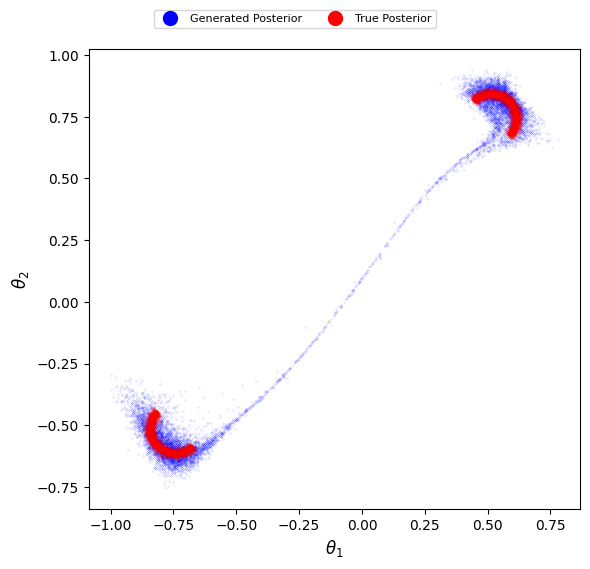

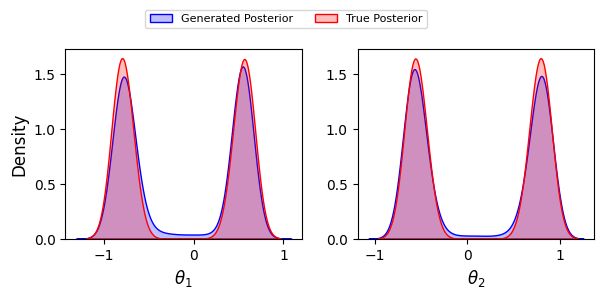

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\two_moons\dataset_2_MAF_two_moons_budget_10k.npz
A dataset for two_moons with 10000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 10
	Number of residual blocks: 2
	Hidden features: 16
	Theta dim: 2
	y dim: 2
Epoch [1/1000] - Train Loss: 3.6757 | Val Loss: 0.7909
Epoch [2/1000] - Train Loss: -0.9015 | Val Loss: -1.6210
Epoch [3/1000] - Train Loss: -1.9879 | Val Loss: -1.4881
Epoch [4/1000] - Train Loss: -1.7559 | Val Loss: -2.4233
Epoch [5/1000] - Train Loss: -2.4837 | Val Loss: -2.3611
Epoch [6/1000] - Train Loss: -2.6593 | Val Loss: -2.8730
Epoch [7/1000] - Train Loss: -2.2482 | Val Loss: -2.8993
Epoch [8/1000] - Train Loss: -2.6719 | Val Loss: -2.7975
Epoch [9/1000] - Train Loss: -2.8359 | Val Loss: -3.1513
Epoc

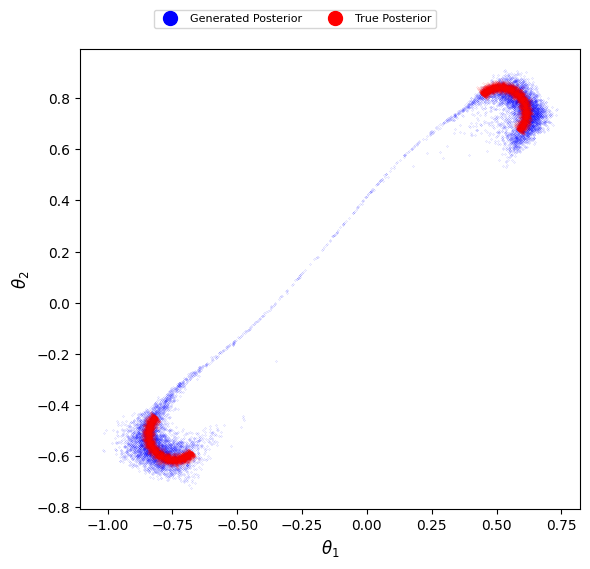

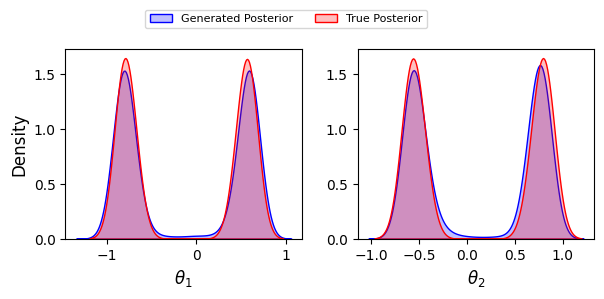

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\two_moons\dataset_3_MAF_two_moons_budget_10k.npz
A dataset for two_moons with 10000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 10
	Number of residual blocks: 2
	Hidden features: 16
	Theta dim: 2
	y dim: 2
Epoch [1/1000] - Train Loss: 4.4943 | Val Loss: 2.7094
Epoch [2/1000] - Train Loss: 2.2893 | Val Loss: 1.8930
Epoch [3/1000] - Train Loss: 1.6858 | Val Loss: 1.5849
Epoch [4/1000] - Train Loss: 1.1583 | Val Loss: 1.0479
Epoch [5/1000] - Train Loss: 0.7946 | Val Loss: 0.2839
Epoch [6/1000] - Train Loss: 0.2193 | Val Loss: -0.1756
Epoch [7/1000] - Train Loss: -0.2235 | Val Loss: -0.4914
Epoch [8/1000] - Train Loss: -0.6392 | Val Loss: -1.0000
Epoch [9/1000] - Train Loss: -0.9673 | Val Loss: -1.3183
Epoch [10/100

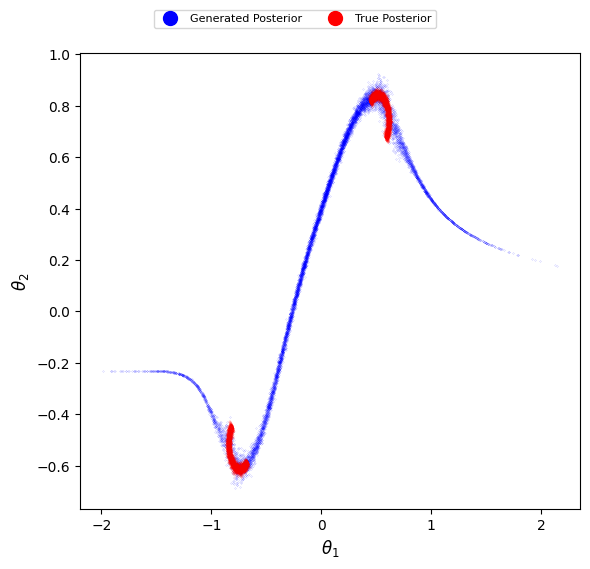

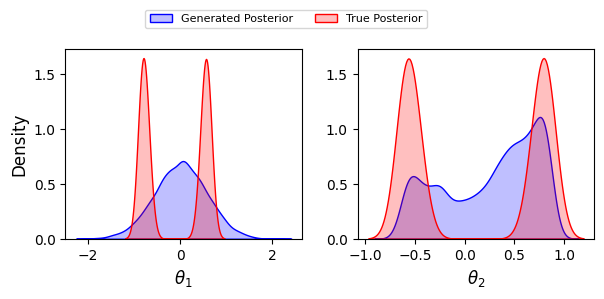

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\two_moons\dataset_4_MAF_two_moons_budget_10k.npz
A dataset for two_moons with 10000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 10
	Number of residual blocks: 2
	Hidden features: 16
	Theta dim: 2
	y dim: 2
Epoch [1/1000] - Train Loss: 2.3855 | Val Loss: -1.7012
Epoch [2/1000] - Train Loss: -1.9665 | Val Loss: -2.5879
Epoch [3/1000] - Train Loss: -2.5245 | Val Loss: -2.7025
Epoch [4/1000] - Train Loss: -2.5572 | Val Loss: -3.1233
Epoch [5/1000] - Train Loss: -2.7593 | Val Loss: -2.6399
Epoch [6/1000] - Train Loss: -2.6675 | Val Loss: -3.2068
Epoch [7/1000] - Train Loss: -2.9880 | Val Loss: -3.4276
Epoch [8/1000] - Train Loss: -3.0508 | Val Loss: -3.3187
Epoch [9/1000] - Train Loss: -2.9816 | Val Loss: -3.2555
Epo

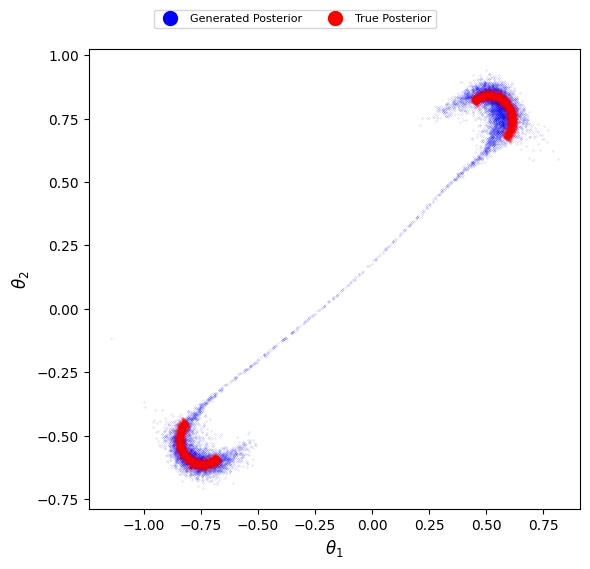

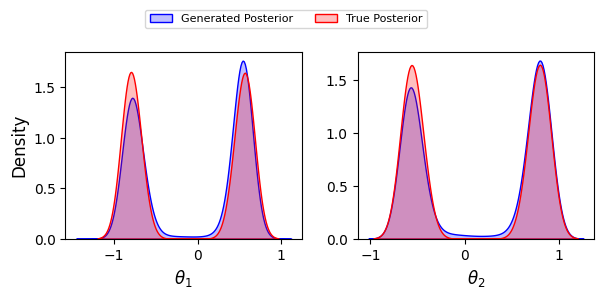

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\two_moons\dataset_5_MAF_two_moons_budget_10k.npz
A dataset for two_moons with 5000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 10
	Number of residual blocks: 2
	Hidden features: 16
	Theta dim: 2
	y dim: 2
Epoch [1/1000] - Train Loss: 4.4951 | Val Loss: 1.4437
Epoch [2/1000] - Train Loss: -0.5282 | Val Loss: -1.1810
Epoch [3/1000] - Train Loss: -1.4002 | Val Loss: -1.8327
Epoch [4/1000] - Train Loss: -1.9509 | Val Loss: -2.3945
Epoch [5/1000] - Train Loss: -2.1212 | Val Loss: -2.5439
Epoch [6/1000] - Train Loss: -2.0410 | Val Loss: -2.3510
Epoch [7/1000] - Train Loss: -2.2174 | Val Loss: -2.2135
Epoch [8/1000] - Train Loss: -2.1867 | Val Loss: -2.6389
Epoch [9/1000] - Train Loss: -2.5087 | Val Loss: -2.4146
Epoch

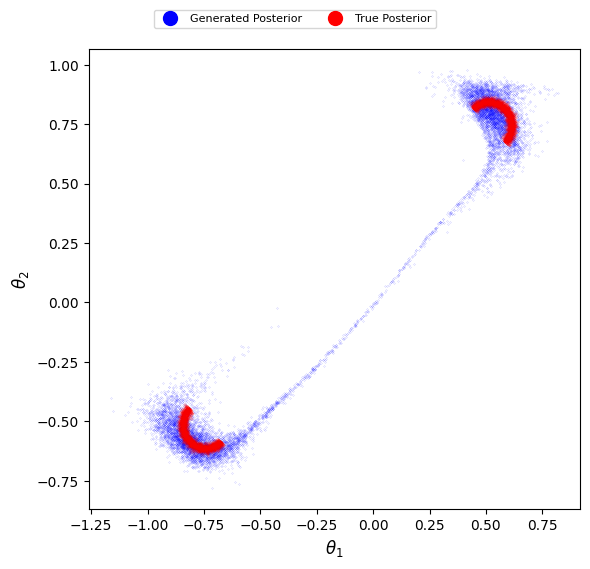

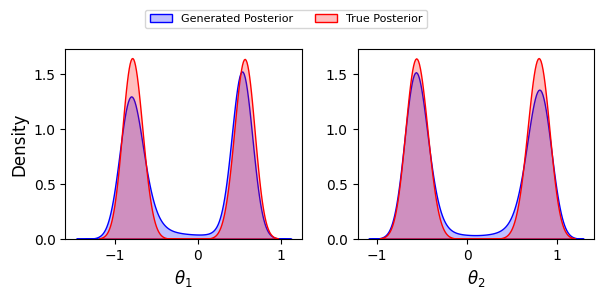

A dataset for two_moons with 5000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 10
	Number of residual blocks: 2
	Hidden features: 16
	Theta dim: 2
	y dim: 2
Epoch [1/1000] - Train Loss: 6.5604 | Val Loss: 3.4355
Epoch [2/1000] - Train Loss: 0.5538 | Val Loss: -0.0985
Epoch [3/1000] - Train Loss: -0.8164 | Val Loss: -1.5349
Epoch [4/1000] - Train Loss: -1.6734 | Val Loss: -2.0671
Epoch [5/1000] - Train Loss: -1.6606 | Val Loss: -2.0273
Epoch [6/1000] - Train Loss: -1.9537 | Val Loss: -2.3079
Epoch [7/1000] - Train Loss: -2.1326 | Val Loss: -2.2896
Epoch [8/1000] - Train Loss: -2.2270 | Val Loss: -2.3489
Epoch [9/1000] - Train Loss: -2.1852 | Val Loss: -2.4778
Epoch [10/1000] - Train Loss: -2.0433 | Val Loss: -2.2673
Epoch [11/1000] - Train Loss: -1.9471 | Val Loss: -2.0941
Epoch [12/1000] - Train Loss: -2.3030 | Val Loss: -2.7553
Epoch [

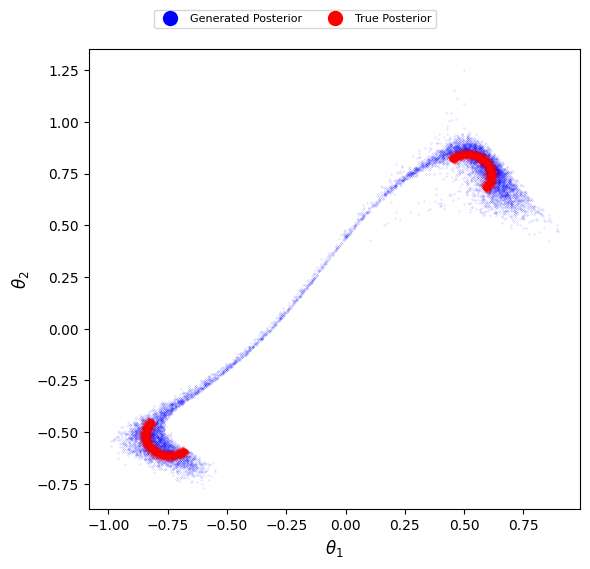

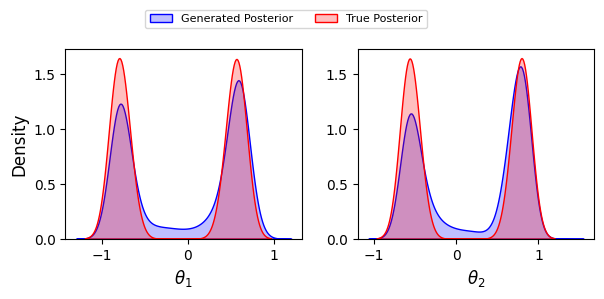

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\two_moons\dataset_2_MAF_two_moons_budget_5k.npz
A dataset for two_moons with 5000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 10
	Number of residual blocks: 2
	Hidden features: 16
	Theta dim: 2
	y dim: 2
Epoch [1/1000] - Train Loss: 4.2024 | Val Loss: 2.2353
Epoch [2/1000] - Train Loss: 1.2087 | Val Loss: 0.5336
Epoch [3/1000] - Train Loss: 0.0152 | Val Loss: -0.4878
Epoch [4/1000] - Train Loss: -0.7971 | Val Loss: -1.1312
Epoch [5/1000] - Train Loss: -1.0129 | Val Loss: -1.3712
Epoch [6/1000] - Train Loss: -0.9687 | Val Loss: -0.9484
Epoch [7/1000] - Train Loss: -1.3275 | Val Loss: -1.7543
Epoch [8/1000] - Train Loss: -1.5827 | Val Loss: -1.7091
Epoch [9/1000] - Train Loss: -1.5900 | Val Loss: -2.0253
Epoch [10

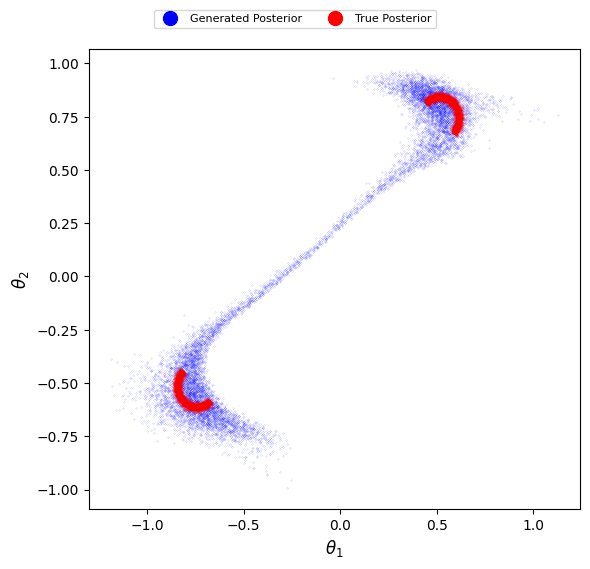

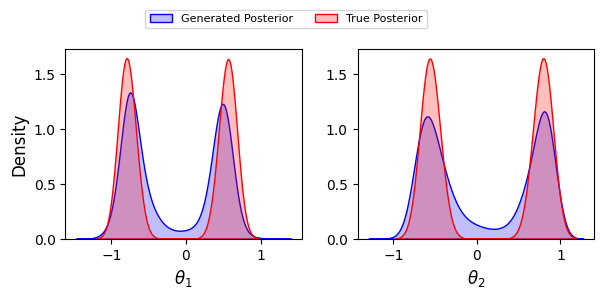

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\two_moons\dataset_3_MAF_two_moons_budget_5k.npz
A dataset for two_moons with 5000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 10
	Number of residual blocks: 2
	Hidden features: 16
	Theta dim: 2
	y dim: 2
Epoch [1/1000] - Train Loss: 5.9038 | Val Loss: 2.6450
Epoch [2/1000] - Train Loss: -0.6371 | Val Loss: 0.8913
Epoch [3/1000] - Train Loss: -1.8732 | Val Loss: -2.3376
Epoch [4/1000] - Train Loss: -2.1488 | Val Loss: -2.1995
Epoch [5/1000] - Train Loss: -2.2647 | Val Loss: -2.6263
Epoch [6/1000] - Train Loss: -2.3237 | Val Loss: -2.5927
Epoch [7/1000] - Train Loss: -2.2552 | Val Loss: -2.8366
Epoch [8/1000] - Train Loss: -2.4446 | Val Loss: -2.3961
Epoch [9/1000] - Train Loss: -2.6437 | Val Loss: -2.6270
Epoch [

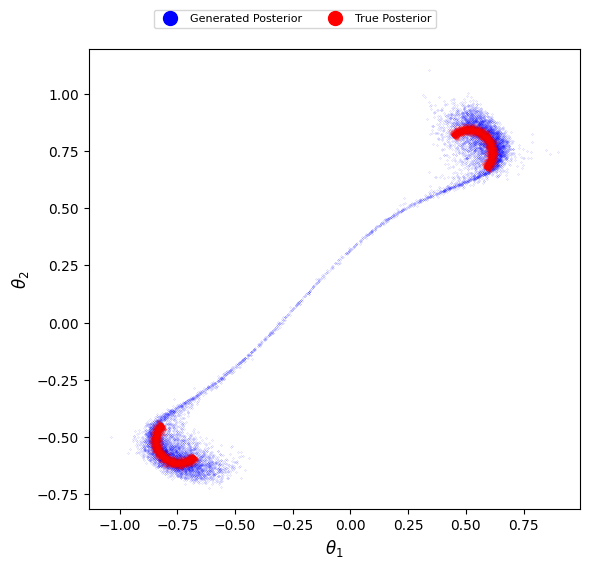

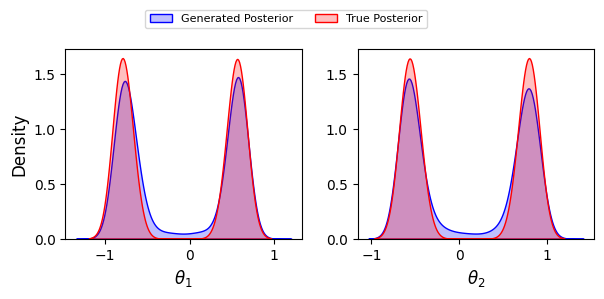

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\two_moons\dataset_4_MAF_two_moons_budget_5k.npz
A dataset for two_moons with 5000 samples already exists
	Model: MAF

	Transformation: <class 'nflows.transforms.autoregressive.MaskedAffineAutoregressiveTransform'>
	Base distribution: StandardNormal()
	Number of transformations: 10
	Number of residual blocks: 2
	Hidden features: 16
	Theta dim: 2
	y dim: 2
Epoch [1/1000] - Train Loss: 5.6427 | Val Loss: 2.0219
Epoch [2/1000] - Train Loss: -0.5194 | Val Loss: -1.7346
Epoch [3/1000] - Train Loss: -1.4035 | Val Loss: -1.9976
Epoch [4/1000] - Train Loss: -1.8302 | Val Loss: -2.1896
Epoch [5/1000] - Train Loss: -2.0972 | Val Loss: -2.4581
Epoch [6/1000] - Train Loss: -2.2796 | Val Loss: -1.9110
Epoch [7/1000] - Train Loss: -2.0546 | Val Loss: -2.5042
Epoch [8/1000] - Train Loss: -2.3937 | Val Loss: -2.6763
Epoch [9/1000] - Train Loss: -2.5061 | Val Loss: -2.3231
Epoch 

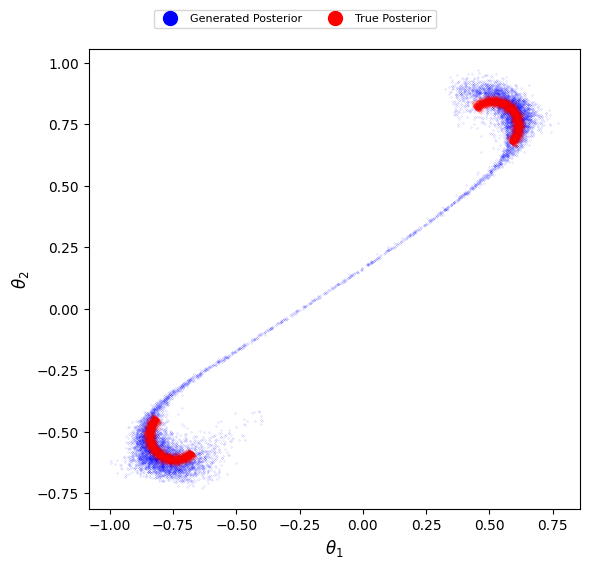

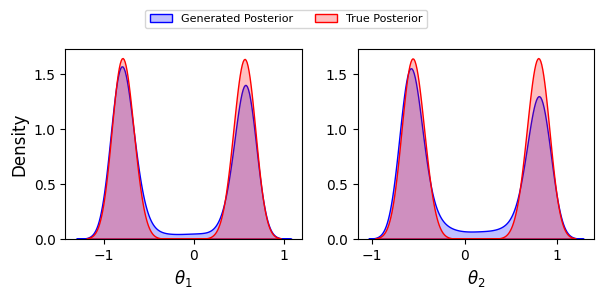

The generated dataset has been saved at:
 c:\Users\cooli\OneDrive\Skrivbord\master thesis\codes\Flow Based Methods\Runs - MAF\two_moons\dataset_5_MAF_two_moons_budget_5k.npz


In [ ]:
models_dep = [{
    "model": Dependent_cVAE,
    "task_name": "gaussian_linear",
    "learning_rate": 5e-4,
    "batch_size": 16,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 10,
    "cvae_beta": 1,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [128,128,128],
    "cvae_decoder_hidden_dim": [128,128],
    "cvae_prior_hidden_dim": [64,64]
},
{
    "model": Dependent_cVAE,
    "task_name": "gaussian_linear_uniform",
    "learning_rate": 5e-4,
    "batch_size": 32,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 10,
    "cvae_beta": 1,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [128,128,128],
    "cvae_decoder_hidden_dim": [128,128],
    "cvae_prior_hidden_dim": [256,256]
},
{
    "model": Dependent_cVAE,
    "task_name": "slcp",
    "learning_rate": 5e-4,
    "batch_size": 16,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 5,
    "cvae_beta": 1,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [128,128,128],
    "cvae_decoder_hidden_dim": [128,128],
    "cvae_prior_hidden_dim": [128,128]
},
{
    "model": Dependent_cVAE,
    "task_name": "slcp_distractors",
    "learning_rate": 5e-4,
    "batch_size": 16,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 8,
    "cvae_beta": 1,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [256,256,256],
    "cvae_decoder_hidden_dim": [256,256],
    "cvae_prior_hidden_dim": [128,128]
},
{
    "model": Dependent_cVAE,
    "task_name": "bernoulli_glm",
    "learning_rate": 5e-4,
    "batch_size": 32,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 10,
    "cvae_beta": 1,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [256,256,256],
    "cvae_decoder_hidden_dim": [256,256,256],
    "cvae_prior_hidden_dim": [64,64,64]
},
{
    "model": Dependent_cVAE,
    "task_name": "bernoulli_glm_raw",
    "learning_rate": 5e-4,
    "batch_size": 32,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 10,
    "cvae_beta": 10,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [256,256,256,256],
    "cvae_decoder_hidden_dim": [256,256,256],
    "cvae_prior_hidden_dim": [128,128,128]
},
{
    "model": Dependent_cVAE,
    "task_name": "gaussian_mixture",
    "learning_rate": 5e-4,
    "batch_size": 16,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 4,
    "cvae_beta": 1,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [128,128,128],
    "cvae_decoder_hidden_dim": [128,128],
    "cvae_prior_hidden_dim": [32]
},
{
    "model": Dependent_cVAE,
    "task_name": "two_moons",
    "learning_rate": 5e-4,
    "batch_size": 32,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 2,
    "cvae_beta": 1,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [128,128,128],
    "cvae_decoder_hidden_dim": [128,128],
    "cvae_prior_hidden_dim": [128,128]
},
{
    "model": Dependent_cVAE,
    "task_name": "sir",
    "learning_rate": 5e-4,
    "batch_size": 32,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 2,
    "cvae_beta": 1,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [128,128,128,128],
    "cvae_decoder_hidden_dim": [128,128,128,128],
    "cvae_prior_hidden_dim": [256,256,256]
},
{
    "model": Dependent_cVAE,
    "task_name": "lotka_volterra",
    "learning_rate": 1e-4,
    "batch_size": 256,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 8,
    "cvae_beta": 10,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [128,128,128],
    "cvae_decoder_hidden_dim": [128,128,128],
    "cvae_prior_hidden_dim": [64,64]
}
]

models_indep = [{
    "model": Independent_cVAE,
    "task_name": "gaussian_linear",
    "learning_rate": 5e-4,
    "batch_size": 16,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 10,
    "cvae_beta": 1,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [128,128,128],
    "cvae_decoder_hidden_dim": [128,128,128]
},
{
    "model": Independent_cVAE,
    "task_name": "gaussian_linear_uniform",
    "learning_rate": 5e-4,
    "batch_size": 32,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 10,
    "cvae_beta": 10,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [128,128,128,128],
    "cvae_decoder_hidden_dim": [128,128,128]
},
{
    "model": Independent_cVAE,
    "task_name": "slcp",
    "learning_rate": 5e-4,
    "batch_size": 16,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 5,
    "cvae_beta": 1,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [512,512,512],
    "cvae_decoder_hidden_dim": [512,512,512]
},
{
    "model": Independent_cVAE,
    "task_name": "slcp_distractors",
    "learning_rate": 5e-4,
    "batch_size": 16,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 5,
    "cvae_beta": 1,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [512,512,512,512],
    "cvae_decoder_hidden_dim": [512,512,512]
},
{
    "model": Independent_cVAE,
    "task_name": "bernoulli_glm",
    "learning_rate": 5e-4,
    "batch_size": 16,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 10,
    "cvae_beta": 1,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [256,256,256,256],
    "cvae_decoder_hidden_dim": [256,256,256,256]
},
{
    "model": Independent_cVAE,
    "task_name": "bernoulli_glm_raw",
    "learning_rate": 5e-4,
    "batch_size": 16,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 5,
    "cvae_beta": 0.1,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [256,256,256,256],
    "cvae_decoder_hidden_dim": [256,256,256,256]
},
{
    "model": Independent_cVAE,
    "task_name": "gaussian_mixture",
    "learning_rate": 5e-4,
    "batch_size": 16,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 2,
    "cvae_beta": 1,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [128,128,128],
    "cvae_decoder_hidden_dim": [128,128]
},
{
    "model": Independent_cVAE,
    "task_name": "two_moons",
    "learning_rate": 5e-4,
    "batch_size": 16,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 2,
    "cvae_beta": 1,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [128,128,128],
    "cvae_decoder_hidden_dim": [128,128]
},
{
    "model": Independent_cVAE,
    "task_name": "sir",
    "learning_rate": 1e-4,
    "batch_size": 64,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 2,
    "cvae_beta": 1,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [128,128,128,128],
    "cvae_decoder_hidden_dim": [128,128]
},
{
    "model": Independent_cVAE,
    "task_name": "lotka_volterra",
    "learning_rate": 1e-4,
    "batch_size": 128,
    "epochs": 50,
    "early_stopping_patience": 20,
    "scaler": StandardScaler,
    "cvae_z_dim": 8,
    "cvae_beta": 1,
    "cvae_gradient_clipping_threshold": 10,
    "cvae_encoder_hidden_dim": [256,256,256,256],
    "cvae_decoder_hidden_dim": [256,256,256]
}
]

models_NSF = [
     {
        "model": NSF,
        "task_name": "slcp",
        "num_samples": 5000,
        "nflows_NSF_spline": PiecewiseRationalQuadraticCouplingTransform,
        "nflows_num_transforms": 4,
        "nflows_hidden_dim": 32,  #
        "nflows_num_blocks": 4,
        "early_stopping_patience": 20,
        "epochs": 50,
        "learning_rate": 1e-4,
        "batch_size": 512,
        "scaler": StandardScaler,
        "nflows_activation_func": F.elu,
        "nflows_use_batch_norm": True,
        "nflows_NSF_tail_bound": 3
    },
    {
        "model": NSF,
        "task_name": "gaussian_linear_uniform",
        "num_samples": 5000,
        "nflows_NSF_spline": PiecewiseRationalQuadraticCouplingTransform,
        "nflows_num_transforms": 4,
        "nflows_hidden_dim": 256,
        "nflows_num_blocks": 3,
        "early_stopping_patience": 20,
        "epochs": 50,
        "learning_rate": 1e-3,
        "batch_size": 128,
        "scaler": StandardScaler,
        "nflows_activation_func": F.elu,
        "nflows_use_batch_norm": True,
        "nflows_NSF_tail_bound": 3
    },
    {
        "model": NSF,
        "task_name": "gaussian_linear",
        "num_samples": 5000,
        "nflows_NSF_spline": PiecewiseRationalQuadraticCouplingTransform,
        "nflows_num_transforms": 3,#2
        "nflows_hidden_dim": 64,#32
        "nflows_num_blocks": 2,
        "early_stopping_patience": 20,
        "epochs": 50,
        "learning_rate": 1e-3,
        "batch_size": 128,
        "scaler": StandardScaler,
        "nflows_activation_func": F.elu,
        "nflows_use_batch_norm": True,
        "nflows_NSF_tail_bound": 3
    },
    {
        "model": NSF,
        "task_name": "slcp_distractors",
        "num_samples": 5000,
        "nflows_NSF_spline": PiecewiseRationalQuadraticCouplingTransform,
        "nflows_num_transforms": 3,#4
        "nflows_hidden_dim": 128,
        "nflows_num_blocks": 3,#5
        "early_stopping_patience": 20,
        "epochs": 1000,
        "learning_rate": 1e-4,
        "batch_size": 512,
        "scaler": StandardScaler,
        "nflows_activation_func": F.elu,
        "nflows_use_batch_norm": True,
        "nflows_NSF_tail_bound": 5,#3
    },
     {
        "model": NSF,
        "task_name": "bernoulli_glm",
        "num_samples": 5000,
        "nflows_NSF_spline": PiecewiseRationalQuadraticCouplingTransform,
        "nflows_num_transforms": 5,
        "nflows_hidden_dim": 32,
        "nflows_num_blocks": 2,
        "early_stopping_patience": 20,
        "epochs": 50,
        "learning_rate": 5e-4,
        "batch_size": 256,
        "scaler": StandardScaler,
        "nflows_activation_func": F.elu,
        "nflows_use_batch_norm": True,
        "nflows_NSF_tail_bound": 6
    },
    {
        "model": NSF,
        "task_name": "bernoulli_glm_raw",
        "num_samples": 5000,
        "nflows_NSF_spline": PiecewiseRationalQuadraticCouplingTransform,
        "nflows_num_transforms": 5,
        "nflows_hidden_dim": 64,
        "nflows_num_blocks": 2,
        "early_stopping_patience": 20,
        "epochs": 1000,
        "learning_rate": 5e-4,
        "batch_size": 128,
        "scaler": StandardScaler,
        "nflows_activation_func": F.elu,
        "nflows_use_batch_norm": True,
        "nflows_NSF_tail_bound": 6
    },
    {
        "model": NSF,
        "task_name": "gaussian_mixture",
        "num_samples": 20000,
        "nflows_NSF_spline": PiecewiseRationalQuadraticCouplingTransform,
        "nflows_num_transforms": 6,
        "nflows_hidden_dim": 128,
        "nflows_num_blocks": 3,
        "early_stopping_patience": 20,
        "epochs": 1000,
        "learning_rate": 5e-4,
        "batch_size": 512,
        "scaler": StandardScaler,
        "nflows_activation_func": F.elu,
        "nflows_use_batch_norm": True,
        "nflows_NSF_tail_bound": 22
    },
    {
        "model": NSF,
        "task_name": "two_moons",
        "num_samples": 20000,
        "nflows_NSF_spline": PiecewiseRationalQuadraticCouplingTransform,
        "nflows_num_transforms": 3,
        "nflows_hidden_dim": 32,
        "nflows_num_blocks": 2,
        "early_stopping_patience": 20,
        "epochs": 1000,
        "learning_rate": 5e-4,
        "batch_size": 512,
        "scaler": StandardScaler,
        "nflows_activation_func": F.elu,
        "nflows_use_batch_norm": True,
        "nflows_NSF_tail_bound": 8
    },
    {
        "model": NSF,
        "task_name": "sir",
        "num_samples": 5000,
        "nflows_NSF_spline": PiecewiseRationalQuadraticCouplingTransform,
        "nflows_num_transforms": 8, 
        "nflows_hidden_dim": 256,
        "nflows_num_blocks": 5, 
        "early_stopping_patience": 20,
        "epochs": 50,
        "learning_rate": 5e-4, 
        "batch_size": 512, 
        "scaler": StandardScaler,
        "nflows_activation_func": F.elu, 
        "nflows_use_batch_norm": True, 
        "nflows_NSF_tail_bound": 12
    },
    {
        "model": NSF,
        "task_name": "lotka_volterra",
        "num_samples": 5000,
        "nflows_NSF_spline": PiecewiseRationalQuadraticCouplingTransform,
        "nflows_num_transforms": 10, 
        "nflows_hidden_dim": 512, 
        "nflows_num_blocks": 4, 
        "early_stopping_patience": 20,
        "epochs": 50,
        "learning_rate": 1e-4, 
        "batch_size": 512, 
        "scaler": StandardScaler,
        "nflows_activation_func": F.elu, 
        "nflows_use_batch_norm": True, 
        "nflows_NSF_tail_bound": 8 
    }

]

models_MAF = [
  {
        "model": MAF,
        "task_name": "gaussian_linear_uniform",
        "num_samples": 5000,
        "nflows_MAF_transform": MaskedAffineAutoregressiveTransform,
        "nflows_num_transforms": 5,
        "nflows_hidden_dim": 32,
        "nflows_num_blocks": 4, 
        "early_stopping_patience": 20,
        "epochs": 1000, 
        "learning_rate": 1e-3,
        "batch_size": 256,
        "scaler": StandardScaler,
        "nflows_activation_func": F.elu,
        "nflows_use_batch_norm": True,
        "seed": 0,
        "save_fig": False,
        "save_generated_dataset": False,
        "save_model": False
    },
    {
        "model": MAF,
        "task_name": "two_moons",
        "num_samples": 5000,
        "nflows_MAF_transform": MaskedAffineAutoregressiveTransform,
        "nflows_num_transforms":10,#10
        "nflows_hidden_dim": 16,#16
        "nflows_num_blocks": 2, #2
        "early_stopping_patience": 20,
        "epochs": 1000, 
        "learning_rate": 1e-3,#
        "batch_size": 128,#
        "scaler": MinMaxScaler,
        "nflows_activation_func": F.elu,
        "nflows_use_batch_norm": True,
        "seed": 0,
        "save_fig": False,
        "save_generated_dataset": False,
        "save_model": False
    },
     {
        "model": MAF,
        "task_name": "bernoulli_glm",
        "num_samples": 5000,
        "nflows_MAF_transform": MaskedAffineAutoregressiveTransform,
        "nflows_num_transforms": 7,#6
        "nflows_hidden_dim": 64,#64
        "nflows_num_blocks": 10, #10
        "early_stopping_patience": 20,
        "epochs": 1000,
        "learning_rate": 1e-3,#1e-4
        "batch_size": 128,#128
        "scaler": MinMaxScaler,
        "nflows_activation_func": F.elu,
        "nflows_use_batch_norm": True,
        "seed": 0,
        "save_fig": False,
        "save_generated_dataset": False,
        "save_model": False
    },
      {
        "model": MAF,
        "task_name": "slcp",
        "num_samples": 5000,
        "nflows_MAF_transform": MaskedAffineAutoregressiveTransform,
        "nflows_num_transforms": 8,#8
        "nflows_hidden_dim": 64,#64
        "nflows_num_blocks": 10, #10
        "early_stopping_patience": 20,
        "epochs": 1000,
        "learning_rate": 1e-4,#1e-4
        "batch_size": 128,#128
        "scaler": MinMaxScaler,
        "nflows_activation_func": F.elu,
        "nflows_use_batch_norm": True,
        "seed": 0,
        "save_fig": False,
        "save_generated_dataset": False,
        "save_model": False
    },
     {
        "model": MAF,
        "task_name": "bernoulli_glm_raw",
        "num_samples": 5000,
        "nflows_MAF_transform": MaskedAffineAutoregressiveTransform,
        "nflows_num_transforms": 9,#6
        "nflows_hidden_dim": 64,#64
        "nflows_num_blocks": 10, #10
        "early_stopping_patience": 20,
        "epochs": 1000,
        "learning_rate": 1e-3,#1e-4
        "batch_size": 128,#128
        "scaler": MinMaxScaler,
        "nflows_activation_func": F.elu,
        "nflows_use_batch_norm": True,
        "seed": 0,
        "save_fig": False,
        "save_generated_dataset": False,
        "save_model": False
    },
      {
        "model": MAF,
        "task_name": "gaussian_linear",
        "num_samples": 5000,
        "nflows_MAF_transform": MaskedAffineAutoregressiveTransform,
        "nflows_num_transforms": 3,
        "nflows_hidden_dim": 8,
        "nflows_num_blocks": 2,
        "early_stopping_patience": 20,
        "epochs": 1000,
        "learning_rate": 1e-3,
        "batch_size": 128,
        "scaler": StandardScaler,
        "nflows_activation_func": F.elu,
        "nflows_use_batch_norm": True,
        "seed": 0,
        "save_fig": False,
        "save_generated_dataset": False,
        "save_model": False
    },
    {
        "model": MAF,
        "task_name": "gaussian_mixture",
        "num_samples": 5000,
        "nflows_MAF_transform": MaskedAffineAutoregressiveTransform,
        "nflows_num_transforms":8,#8
        "nflows_hidden_dim": 2,#4
        "nflows_num_blocks": 8, #8
        "early_stopping_patience": 20,
        "epochs": 1000,
        "learning_rate": 1e-3,#1e-3
        "batch_size": 256,#128
        "scaler": MinMaxScaler,
        "nflows_activation_func": F.elu,
        "nflows_use_batch_norm": True,
        "seed": 0,
        "save_fig": False,
        "save_generated_dataset": False,
        "save_model": False
    },
    {
        "model": MAF,
        "task_name": "sir",
        "num_samples": 5000,
        "nflows_MAF_transform": MaskedAffineAutoregressiveTransform,
        "nflows_num_transforms":10,#10
        "nflows_hidden_dim": 16,#8
        "nflows_num_blocks": 4,#4
        "early_stopping_patience": 20,
        "epochs": 1000,
        "learning_rate": 1e-3,#
        "batch_size": 128,#
        "scaler": MinMaxScaler,
        "nflows_activation_func": F.elu,
        "nflows_use_batch_norm": True,
        "seed": 0,
        "save_fig": False,
        "save_generated_dataset": False,
        "save_model": False
    },
    {
        "model": MAF,
        "task_name": "lotka_volterra",
        "num_samples": 5000,
        "nflows_MAF_transform": MaskedAffineAutoregressiveTransform,
        "nflows_num_transforms":8,#10
        "nflows_hidden_dim": 64,#8
        "nflows_num_blocks": 10,#4
        "early_stopping_patience": 20,
        "epochs": 1000,
        "learning_rate": 1e-3,#
        "batch_size": 128,#
        "scaler": MinMaxScaler,
        "nflows_activation_func": F.elu,
        "nflows_use_batch_norm": True,
        "seed": 0,
        "save_fig": False,
        "save_generated_dataset": False,
        "save_model": False
    }
]




for task in models_MAF:
    for num_samples in [20000,10000,5000]:
        for i in range(0,5):
            if i == 0 and num_samples == 20000:
                torch.cuda.empty_cache()
                run_model(
                    model = task["model"],
                    task_name = task["task_name"],
                    num_samples = num_samples,
                    nflows_MAF_transform = task["nflows_MAF_transform"],
                    nflows_num_transforms = task["nflows_num_transforms"],
                    nflows_hidden_dim = task["nflows_hidden_dim"],
                    nflows_num_blocks = task["nflows_num_blocks"],
                    early_stopping_patience = task["early_stopping_patience"],
                    epochs = 1000, 
                    learning_rate = task["learning_rate"],
                    batch_size = task["batch_size"],
                    scaler = task["scaler"],
                    nflows_activation_func = task["nflows_activation_func"],
                    nflows_use_batch_norm = task["nflows_use_batch_norm"],
                    seed = i,
                    save_fig = True,
                    save_generated_dataset = True,
                    save_model = False
                )
            else:
                torch.cuda.empty_cache()
                run_model(
                    model = task["model"],
                    task_name = task["task_name"],
                    num_samples = num_samples,
                    nflows_MAF_transform = task["nflows_MAF_transform"],
                    nflows_num_transforms = task["nflows_num_transforms"],
                    nflows_hidden_dim = task["nflows_hidden_dim"],
                    nflows_num_blocks = task["nflows_num_blocks"],
                    early_stopping_patience = task["early_stopping_patience"],
                    epochs = 1000, 
                    learning_rate = task["learning_rate"],
                    batch_size = task["batch_size"],#
                    scaler = task["scaler"],
                    nflows_activation_func = task["nflows_activation_func"],
                    nflows_use_batch_norm = task["nflows_use_batch_norm"],
                    seed = i,
                    save_fig = False,
                    save_generated_dataset = True,
                    save_model = False
                )